### EL siguiente archivo a continuación contiene la LIMPIEZA DE DATOS Y TRATAMIENTO DE NULOS, LAS VISUALIZACIONES POSTERIORES Y EL DESARROLLO DEL BONUS

### LIMPIEZA DE DATOS


- Se van a eliminar o tratar los valores nulos, si los hay, en las columnas clave para asegurar que los datos están completos.
- Se va a verificar la consistencia y corrección de los datos para una presentación de los mismos coherente. 
- Se realizará cualquier ajuste o conversión necesaria en las columnas, por ejemplo cambiar tipos de datos para garantizar la adecuación de los datos para el analísis estadístico.
- Se va a eliminar una columna que resulta redundante en el conjunto de datos (Dollar Cost points Redeemed).
- Se van a unificar dos columnas (country y city)

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ver todas las columnas
pd.set_option('display.max_columns', None)

In [3]:
# ver todas las filas
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv("union_conjunto.csv")

En primer lugar reutilizamos la función EDA que hemos creado al principio para tener una visión general del conjunto de datos ya unido:

In [5]:
def eda(df):
    
    # SHAPE
    
    print(f"\n SHAPE del DataFrame: {df.shape[0]} filas × {df.shape[1]} columnas")

    # PRIMERAS Y ÚLTIMAS FILAS
    
    print("\n Primeras 5 filas:")
    display(df.head())
    print("\n Últimas 5 filas:")
    display(df.tail())

    # INFORMACIÓN GENERAL
    
    print("\nInformación general:")
    df.info()

    print("\nTipos de datos por columna:")
    print(df.dtypes.value_counts())
    print("\nDetalle:")
    display(df.dtypes.to_frame("Tipo de dato"))
    
    # CONTEO DE COLUMNAS POR TIPO
    
    num_cols = df.select_dtypes(include="number").columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    print(f"\n Columnas numéricas: {len(num_cols)}")
    print(f"Columnas categóricas: {len(cat_cols)}")
    
    # BLOQUE NUMÉRICO
    
    if len(num_cols) > 0:
        print("\n Estadísticas descriptivas (numéricas):")
        display(df[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

        # Detección de outliers (IQR)
        Q1 = df[num_cols].quantile(0.25)
        Q3 = df[num_cols].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).sum()
        outliers = outliers[outliers > 0]
        if not outliers.empty:
            print("\n Posibles outliers detectados (por número de filas afectadas):")
            display(outliers.to_frame("Filas con outliers"))
        else:
            print("\n No se detectaron outliers significativos por el método IQR.")
    else:
        outliers = pd.Series(dtype=int)  # evitar error si no hay columnas numéricas

    # BLOQUE CATEGÓRICO
    
    if len(cat_cols) > 0:
        print("\nEstadísticas descriptivas (categóricas):")
        display(df[cat_cols].describe().T)
    else:
        print("\n No hay columnas categóricas en el DataFrame.")

    
    # VALORES NULOS Y DUPLICADOS
    
    print("\nValores nulos por columna:")
    nulos_df = pd.DataFrame({
        "Nulos": df.isnull().sum(),
        "% Nulos": (df.isnull().mean() * 100).round(2)
    }).sort_values("% Nulos", ascending=False)
    if nulos_df["Nulos"].sum() == 0:
        print(" No hay valores nulos en el DataFrame.")
    display(nulos_df)

    dup_count = df.duplicated().sum()
    if dup_count == 0:
        print("\n No hay filas duplicadas.")
    else:
        print(f"\n Filas duplicadas: {dup_count:,}")

    
    # VALORES ÚNICOS Y RESUMEN GENERAL
    
    print("\nValores únicos por columna:")
    display(df.nunique().sort_values(ascending=False).to_frame("Valores únicos"))

    resumen = pd.DataFrame({
        "Columna": df.columns,
        "Tipo": df.dtypes.astype(str),
        "Valores únicos": df.nunique().values,
        "% Nulos": (df.isnull().mean() * 100).round(2).values
    })
    print("\nResumen general de columnas:")
    display(resumen)

    
    # RESUMEN FINAL DE NULOS Y OUTLIERS
    
    print("\n Resumen de columnas con valores nulos:")
    resumen_nulos = nulos_df[nulos_df["Nulos"] > 0].copy()
    if not resumen_nulos.empty:
        resumen_nulos["Tipo de dato"] = df[resumen_nulos.index].dtypes.astype(str).values
        display(resumen_nulos[["Tipo de dato", "Nulos", "% Nulos"]])
    else:
        print(" No hay columnas con valores nulos.")

    print("\n Resumen de columnas con outliers:")
    if not outliers.empty:
        resumen_outliers = pd.DataFrame({
            "Columna": outliers.index,
            "Tipo de dato": df[outliers.index].dtypes.astype(str).values,
            "Filas con outliers": outliers.values
        }).set_index("Columna")
        display(resumen_outliers)
    else:
        print(" No hay columnas con outliers detectados.")

    return resumen


In [6]:
print("EDA para df")
resumen = eda(df)

EDA para df

 SHAPE del DataFrame: 403760 filas × 25 columnas

 Primeras 5 filas:


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,NaN,Single,Nova,2887.74,Standard,2013,3,NaN,NaN
2,100140,2017,1,6,0,6,1200,120.0,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,NaN,Divorced,Nova,2838.07,Standard,2016,7,NaN,NaN
3,100214,2017,1,0,0,0,0,0.0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.57,Standard,2015,8,NaN,NaN
4,100272,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.05,Standard,2014,1,NaN,NaN



 Últimas 5 filas:


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
403755,999902,2018,12,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,NaN,Married,Aurora,7290.07,Standard,2014,5,NaN,NaN
403756,999911,2018,12,0,0,0,0,0.0,0,0,Canada,Newfoundland,St. John's,A1C 6H9,Male,Doctor,217943.0,Single,Nova,8564.77,Standard,2012,8,NaN,NaN
403757,999940,2018,12,3,0,3,1233,123.0,0,0,Canada,Quebec,Quebec City,G1B 3L5,Female,Bachelor,47670.0,Married,Nova,20266.50,Standard,2017,7,NaN,NaN
403758,999982,2018,12,0,0,0,0,0.0,0,0,Canada,British Columbia,Victoria,V10 6T5,Male,College,NaN,Married,Star,2631.56,Standard,2018,7,NaN,NaN
403759,999986,2018,12,0,0,0,0,0.0,0,0,Canada,Ontario,Ottawa,K1F 2R2,Female,Bachelor,46594.0,Married,Nova,8257.01,2018 Promotion,2018,2,NaN,NaN



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403760 entries, 0 to 403759
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               403760 non-null  int64  
 1   Year                         403760 non-null  int64  
 2   Month                        403760 non-null  int64  
 3   Flights Booked               403760 non-null  int64  
 4   Flights with Companions      403760 non-null  int64  
 5   Total Flights                403760 non-null  int64  
 6   Distance                     403760 non-null  int64  
 7   Points Accumulated           403760 non-null  float64
 8   Points Redeemed              403760 non-null  int64  
 9   Dollar Cost Points Redeemed  403760 non-null  int64  
 10  Country                      403760 non-null  object 
 11  Province                     403760 non-null  object 
 12  City                         403760 

,Tipo de dato
Loyalty Number,int64
Year,int64
Month,int64
Flights Booked,int64
Flights with Companions,int64
Total Flights,int64
Distance,int64
Points Accumulated,float64
Points Redeemed,int64
Dollar Cost Points Redeemed,int64



 Columnas numéricas: 16
Columnas categóricas: 9

 Estadísticas descriptivas (numéricas):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Loyalty Number,403760.0,549875.383713,258961.514684,100018.00,108481.00,144879.00,326699.00,550598.00,772152.00,954750.00,990728.00,999986.00
Year,403760.0,2017.500352,0.500000,2017.00,2017.00,2017.00,2017.00,2018.00,2018.00,2018.00,2018.00,2018.00
Month,403760.0,6.501335,3.451982,1.00,1.00,1.00,4.00,7.00,10.00,12.00,12.00,12.00
Flights Booked,403760.0,4.134050,5.230064,0.00,0.00,0.00,0.00,1.00,8.00,15.00,18.00,21.00
Flights with Companions,403760.0,1.036569,2.080472,0.00,0.00,0.00,0.00,0.00,1.00,6.00,9.00,11.00
Total Flights,403760.0,5.170619,6.526858,0.00,0.00,0.00,0.00,1.00,10.00,18.00,24.00,32.00
Distance,403760.0,1214.460979,1434.098521,0.00,0.00,0.00,0.00,525.00,2342.00,3926.00,4851.00,6293.00
Points Accumulated,403760.0,124.263761,146.696179,0.00,0.00,0.00,0.00,53.00,240.00,402.00,495.00,676.50
Points Redeemed,403760.0,30.838587,125.758002,0.00,0.00,0.00,0.00,0.00,0.00,390.00,638.00,876.00
Dollar Cost Points Redeemed,403760.0,2.495973,10.172033,0.00,0.00,0.00,0.00,0.00,0.00,32.00,52.00,71.00



 Posibles outliers detectados (por número de filas afectadas):


,Filas con outliers
Flights Booked,528
Flights with Companions,71560
Total Flights,1984
Distance,125
Points Accumulated,112
Points Redeemed,24181
Dollar Cost Points Redeemed,24181
Salary,13241
CLV,35941



Estadísticas descriptivas (categóricas):


,count,unique,top,freq
Country,403760,1,Canada,403760
Province,403760,11,Ontario,130258
City,403760,29,Toronto,80775
Postal Code,403760,55,V6E 3D9,21944
Gender,403760,2,Female,202757
Education,403760,5,Bachelor,252567
Marital Status,403760,3,Married,234845
Loyalty Card,403760,3,Star,183745
Enrollment Type,403760,2,Standard,380419



Valores nulos por columna:


,Nulos,% Nulos
Cancellation Month,354110,87.70
Cancellation Year,354110,87.70
Salary,102260,25.33
Year,0,0.00
Flights with Companions,0,0.00
Total Flights,0,0.00
Month,0,0.00
Flights Booked,0,0.00
Loyalty Number,0,0.00
Points Redeemed,0,0.00



 No hay filas duplicadas.

Valores únicos por columna:


,Valores únicos
Loyalty Number,16737
CLV,7984
Salary,5890
Distance,4746
Points Accumulated,1549
Points Redeemed,587
Postal Code,55
Dollar Cost Points Redeemed,49
Total Flights,33
City,29



Resumen general de columnas:


,Columna,Tipo,Valores únicos,% Nulos
Loyalty Number,Loyalty Number,int64,16737,0.00
Year,Year,int64,2,0.00
Month,Month,int64,12,0.00
Flights Booked,Flights Booked,int64,22,0.00
Flights with Companions,Flights with Companions,int64,12,0.00
Total Flights,Total Flights,int64,33,0.00
Distance,Distance,int64,4746,0.00
Points Accumulated,Points Accumulated,float64,1549,0.00
Points Redeemed,Points Redeemed,int64,587,0.00
Dollar Cost Points Redeemed,Dollar Cost Points Redeemed,int64,49,0.00



 Resumen de columnas con valores nulos:


,Tipo de dato,Nulos,% Nulos
Cancellation Month,float64,354110,87.70
Cancellation Year,float64,354110,87.70
Salary,float64,102260,25.33



 Resumen de columnas con outliers:


,Tipo de dato,Filas con outliers
Columna,,
Flights Booked,int64,528
Flights with Companions,int64,71560
Total Flights,int64,1984
Distance,int64,125
Points Accumulated,float64,112
Points Redeemed,int64,24181
Dollar Cost Points Redeemed,int64,24181
Salary,float64,13241
CLV,float64,35941


#### 1. TRATAMIENTO DE VALORES NULOS

Observamos que son 3 las columnas que presentan nulos:
- Cancellation Month, de tipo float64, con un porcentaje de nulos del 87,70 %.
- Cancellation Year, de tipo float64, con un porcentaje de nulos del 87,70 %.
- Salary, de tipo float64, con un porcentaje de nulos del 25,33 %.

Es de crucial importancia que los datos que se vean afectados por el tratamiento de nulos, sean del tipo correcto. No se trata de hacer conversiones innecesarias, que vendrán después en el caso de que sea preciso, de lo que se trata es de asegurarse que la gestión de nulos se va a llevar a cabo de forma lógica y sin errores.

Vamos a reutilizar la parte del código de gráficas que hicimos en la función EDA, para visualizar nuestros datos y tomar decisiones lógicas de tratamiento de nulos en base a las gráficas:

In [6]:
def plot_column(df, col):
    """
    Genera una visualización individual de una columna:
    - Si es numérica: histograma + boxplot
    - Si es categórica: gráfico de barras (máx. 20 categorías)
    """

    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    #  Estilo global 
    sns.set_theme(style="whitegrid", context="talk")
    plt.rcParams.update({
        "figure.figsize": (10, 5),
        "axes.titlesize": 16,
        "axes.labelsize": 13,
        "axes.edgecolor": "#333333",
        "axes.linewidth": 0.8,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"]
    })

    color_hist = "#4B8BBE"   # Azul corporativo
    color_box = "#E07A5F"    # Coral oscuro
    color_bars = sns.color_palette("crest")

    # Validaciones básicas
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return

    data = df[col].dropna()
    if data.empty:
        print(f"La columna '{col}' está vacía o tiene solo valores nulos.")
        return

    # === Diferenciar tipo de dato ===
    if pd.api.types.is_numeric_dtype(data):
        # ---------------- NUMÉRICA ----------------
        media = data.mean()
        mediana = data.median()
        moda = data.mode().iloc[0] if not data.mode().empty else np.nan

        fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})
        fig.suptitle(f"Distribución y Boxplot de {col}", fontsize=16, y=1.05)

        # Histograma + KDE
        sns.histplot(
            data,
            kde=True,
            bins=30,
            color=color_hist,
            edgecolor="white",
            alpha=0.9,
            ax=axes[0]
        )
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Frecuencia")
        axes[0].set_title("Histograma")

        # Líneas verticales: media, mediana, moda
        axes[0].axvline(media, color="#6c757d", linestyle='-', linewidth=2)
        axes[0].axvline(mediana, color="#2ca02c", linestyle='--', linewidth=2)
        axes[0].axvline(moda, color="#d62728", linestyle=':', linewidth=2)

        handles = [
            Line2D([0], [0], color="#6c757d", linestyle='-', linewidth=3),
            Line2D([0], [0], color="#2ca02c", linestyle='--', linewidth=3),
            Line2D([0], [0], color="#d62728", linestyle=':', linewidth=3)
        ]
        labels = [
            f"Media: {media:.2f}",
            f"Mediana: {mediana:.2f}",
            f"Moda: {moda:.2f}"
        ]
        legend = axes[0].legend(
            handles, labels,
            loc='lower right',
            frameon=True,
            facecolor='white',
            edgecolor='#aaaaaa',
            fontsize=10,
            fancybox=True
        )
        legend.get_frame().set_alpha(0.85)

        # Boxplot
        sns.boxplot(
            y=data,
            color=color_box,
            ax=axes[1],
            fliersize=3
        )
        axes[1].set_xlabel("")
        axes[1].set_ylabel("")
        axes[1].set_title("Boxplot")

        plt.tight_layout()
        plt.show()

    else:
        #  CATEGÓRICA 
        plt.figure(figsize=(10, 5))
        order = data.value_counts().index[:20]
        sns.countplot(
            x=col,
            data=df,
            order=order,
            palette=color_bars,
            edgecolor="black"
        )
        plt.title(f"Distribución de {col}", pad=15)
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=40, ha='right')
        plt.tight_layout()
        plt.show()

#### 1. Variable Salary

Ingreso anual estimado del cliente.

Presenta un 3.28 % de valores atípicos u outliers. 

Presenta un 25.33 % de valores nulos. Es decir, salarios ausentes. 

Su tipo es float, con lo cual lo consideramos válido para el tratamiento de nulos.



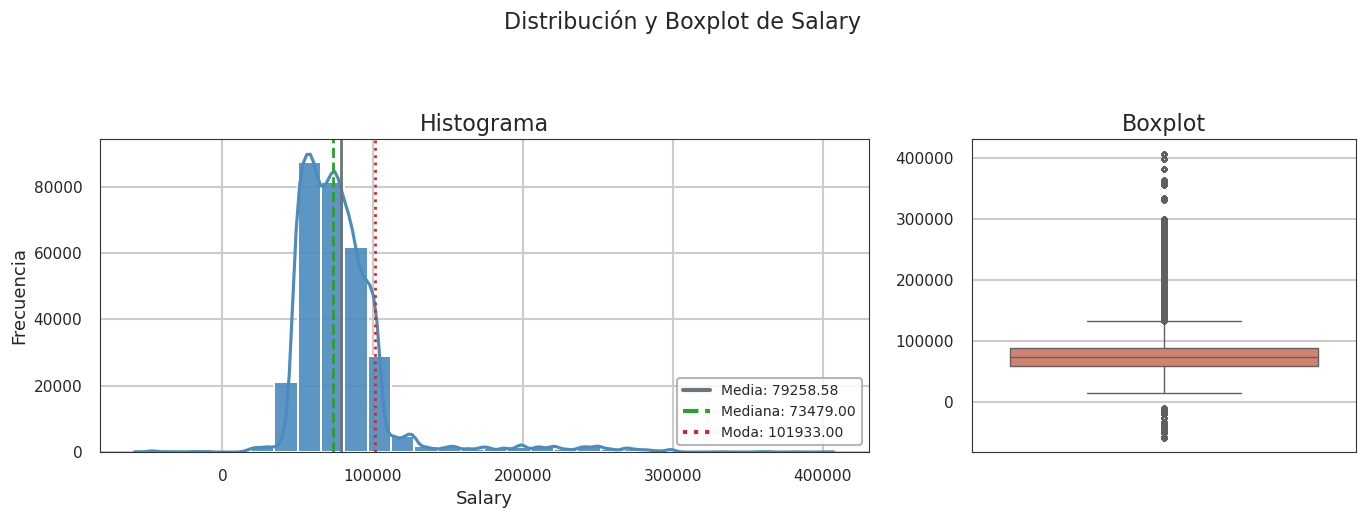

In [7]:
plot_column(df, "Salary")

**Interpretación del histograma y boxplot**

El eje X del histograma muestra los valores de salario anual y el eje Y  representa la frecuencia de clientes en cada rango salarial.
 
El histograma evidencia que la mayoría de los clientes se concentran entre los 50.000 Y 100.000 dólares anuales, donde se agrupa el grueso de los valores.

Sin embargo, se observan algunos valores negativos, posiblemente debidos a errores registrales o imputaciones incorrectas, y una cola larga hacia la derecha, causada por clientes con salarios excepcionalmente altos.


Las tres medidas de tendencia central indican una distribución ligeramente asimétrica:

El promedio de ingresos (media) se sitúa alrededor de 79 mil dólares, la mitad de los clientes (mediana) gana menos de 74 mil dólares y el valor más frecuente está próximo a los 102 mil dólares.  La media superior a la mediana refuerza el sesgo positivo (hacia la derecha), provocado por unos pocos clientes con ingresos muy elevados.


En el boxplot podemos ver los outliers, que representan el 3,28 %, es decir, clientes con salarios muy altos, superando incluso los 400000 dólares. También se aprecian los valores negativos aislados,  que podrían considerarse anómalos o erróneos.


**Conclusión analítica**

La variable Salary presenta una distribución asimétrica a la derecha, con la mayoría de los clientes dentro de un rango medio-alto y una minoría con salarios muy elevados que pueden influir de forma significativa en la media. 

Existen outliers (3.28 %) que representan a clientes con altos ingresos, potencialmente relevantes para estrategias de fidelización y se detecta 25.33 % de valores nulos, un nivel considerable que debe tratarse antes de cualquier análisis estadístico.  Los valores negativos no tienen sentido en esta variable y deben corregirse o eliminarse.




**Tratamiento de nulos**

Se ha optado por una imputación por mediana, concretamente siguiendo un enfoque jerárquico por mediana de grupo, dado que Salary es una variable continua y asimétrica, característica típica de las distribuciones salariales. La elección de la mediana garantiza robustez frente a valores atípicos y resulta coherente con la naturaleza socioeconómica de la variable.

La imputación se ha realizado de forma progresiva y jerárquica, utilizando combinaciones de variables relacionadas con el nivel salarial: Province, Education y Gender.
En primer lugar, se sustituyeron los valores faltantes por la mediana del grupo más específico (Province + Education + Gender).
En caso de no disponer de datos suficientes en ese nivel, se recurrió a agrupaciones más amplias, primero Education + Gender, y posteriormente únicamente Education.
Por último, los valores que aún permanecían nulos se imputaron con la mediana global de la variable.

No se optó por el método KNN Imputer, aunque fue valorado como alternativa, porque, pese a ser una técnica avanzada, tiende a suavizar la varianza e introducir cierto ruido al generar valores intermedios que pueden distorsionar la distribución salarial original.
Asimismo, la media se descartó desde el principio, tanto por el alto porcentaje de valores ausentes como por la presencia de outliers, ya que habría introducido sesgo y reducido la representatividad del conjunto.



In [8]:
# IMPUTACIÓN DE NULOS EN 'Salary' POR MEDIANA JERÁRQUICA


# Verificamos porcentaje de nulos antes de imputar
print(f"Porcentaje de nulos en Salary antes de imputar: {df['Salary'].isna().mean() * 100:.2f} %")

# Definimos el orden de jerarquía para imputar
group_orders = [
    ["Province", "Education", "Gender"],  # más específico
    ["Education", "Gender"],              # intermedio
    ["Education"]                         # más general
]

# Imputamos de forma jerárquica con la mediana por grupo
for groups in group_orders:
    mediana_por_grupo = df.groupby(groups)["Salary"].transform("median")
    df["Salary"] = df["Salary"].fillna(mediana_por_grupo)

# Si aún quedan valores nulos, imputamos con la mediana global
df["Salary"] = df["Salary"].fillna(df["Salary"].median())

#  Verificamos el resultado
print(f"Porcentaje de nulos en Salary después de imputar: {df['Salary'].isna().mean() * 100:.2f} %")
print("\nResumen estadístico de Salary tras imputación:")
print(df["Salary"].describe().round(2))

Porcentaje de nulos en Salary antes de imputar: 25.33 %
Porcentaje de nulos en Salary después de imputar: 0.00 %

Resumen estadístico de Salary tras imputación:
count    403760.00
mean      77794.79
std       30335.16
min      -58486.00
25%       63901.00
50%       73479.00
75%       82940.00
max      407228.00
Name: Salary, dtype: float64


Más adelante, en la función de limpieza de datos, se corregirán los valores negativos de esta variable.

#### 2 y 3. Variables Cancellation Year y Cancellation Month

La primera representa el año en que cliente canceló su membresía en el programa de lealtad, si aplica. No presenta valores atípicos u outliers. Presenta un gran porcentaje de nulos 87.70 %.

La segunda representa el mes en que el cliente canceló su membresía en el programa de lealtad, si aplica. No presenta valores atípicos u outliers. Presenta un porcentaje muy alto de nulos de 87,70 %.


Las gráficas correspondientes a cada una de estas variables son las siguientes:

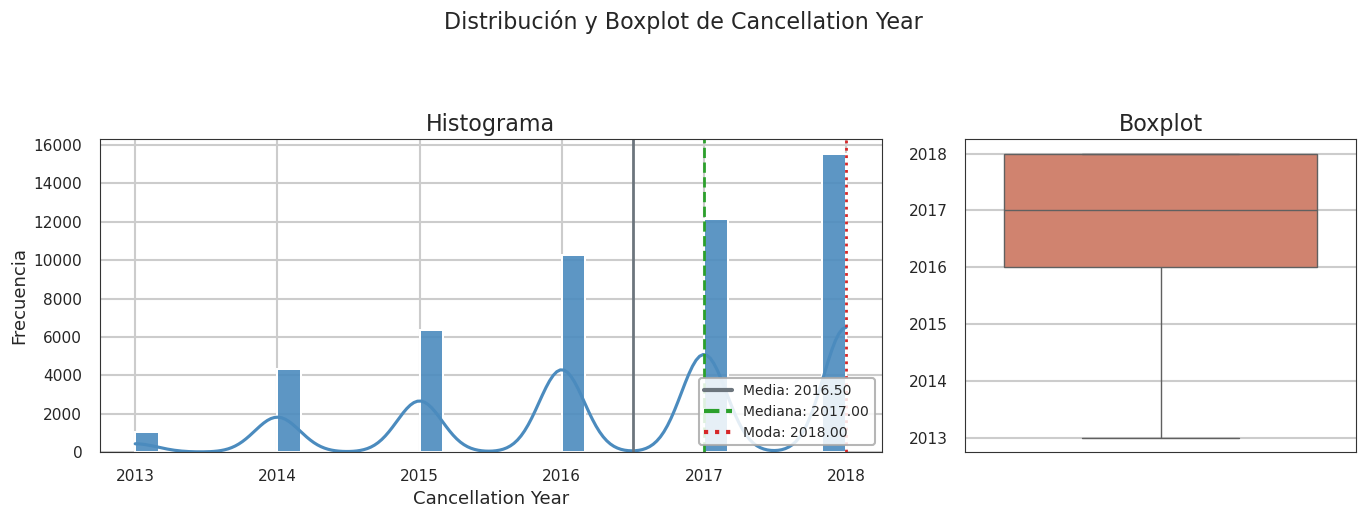

In [9]:
plot_column(df, "Cancellation Year")

**Interpretación del histograma y boxplot**

El eje X del histograma muestra los años de cancelación (2013–2018), mientras que el eje Y representa la frecuencia de cancelaciones registradas en cada año.

La mayor cantidad de cancelaciones se concentró en los años 2017 y 2018, mostrando un incremento notable hacia el final del periodo. Los años anteriores (2013–2016) presentan volúmenes considerablemente menores, lo que sugiere una evolución temporal en la cantidad de cancelaciones.

En cuanto a las medidas de tendencia central, aunque se incluyen en el gráfico, no resulta apropiado analizarlas estadísticamente, ya que los años son una variable temporal discreta y ordinal, no continua.

El boxplot confirma que la mayoría de las cancelaciones se concentraron entre 2016 y 2018, sin valores atípicos (outliers). Esto es lógico, dado que los años están dentro de un rango acotado.

En conjunto, ambos gráficos muestran una tendencia creciente de cancelaciones en los años más recientes.


**Conclusiones analíticas**

La variable no presenta outliers, pero sí un 87.7 % de valores nulos, que corresponden a clientes que no han cancelado su membresía si atendemos a la definición de la variable ("si aplica"). 

Entre los clientes que sí cancelaron, la mayoría lo hizo entre 2016 y 2018, con un pico máximo en 2018.



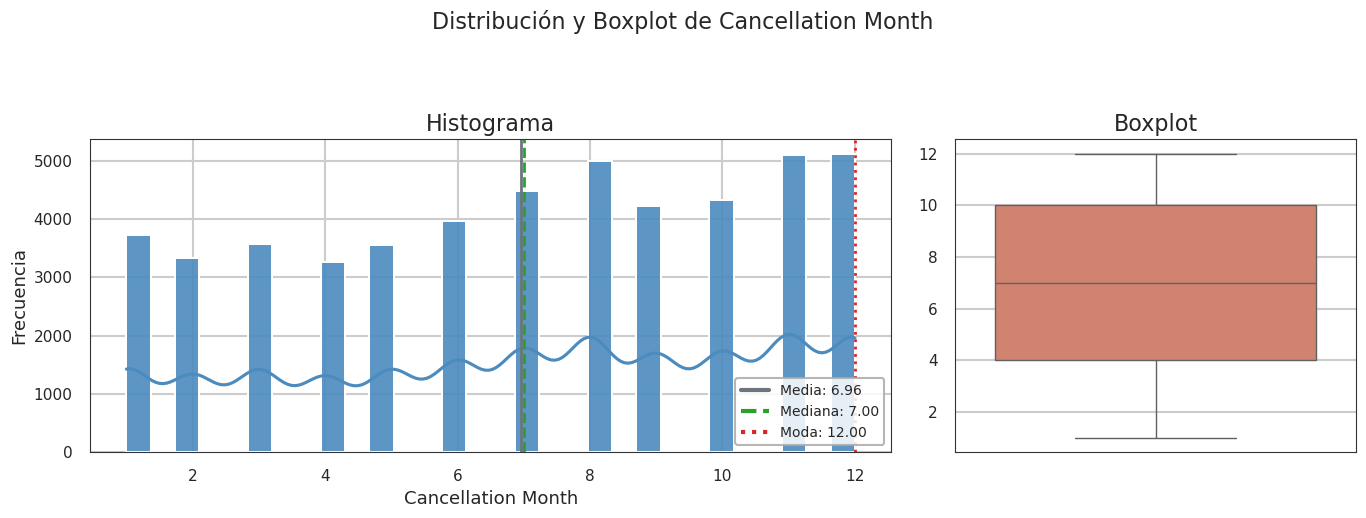

In [10]:
plot_column(df, "Cancellation Month")

**Interpretación del histograma y del boxplot**

El eje X del histograma representa los meses del año (1 a 12), mientras que el eje Y muestra la cantidad de cancelaciones registradas en cada mes.

La distribución de cancelaciones es bastante uniforme a lo largo del año, sin picos pronunciados que indiquen una estacionalidad marcada.
No obstante, se observa una ligera tendencia a un mayor número de cancelaciones en los meses finales del año (especialmente diciembre, mes 12), que podría coincidir con cierres de ciclo o vencimientos de puntos.

Dado que esta variable representa meses, no tiene sentido interpretar medidas como la media, mediana o moda en un sentido numérico, ya que el mes no es una magnitud continua sino una categoría ordinal temporal.


**Conclusiones analíticas**

La variable Cancellation Month no presenta valores atípicos, pero sí un 87,70 % de valores nulos, que corresponden a clientes que no han cancelado su membresía y, por tanto, permanecen activos si atendemos a la propia definición de la variable ("si aplica").

Entre quienes sí cancelaron, las cancelaciones están uniformemente distribuidas a lo largo del año, con una leve concentración en los meses finales.



**TRATAMIENTO DE  NULOS DE AMBAS VARIABLES**

Antes de proceder al tratamiento de los valores nulos, es importante realizar una aclaración. Las variables Cancellation Year y Cancellation Month representan el año y el mes, respectivamente, en que un cliente canceló su membresía, por lo que su naturaleza es discreta y entera. Sin embargo, debido a la presencia de valores nulos, pandas almacena estas columnas originalmente como float64, ya que los valores NaN no son compatibles con tipos enteros convencionales.

Para reflejar correctamente la naturaleza de las variables, dado que no tiene sentido expresar años o meses como números decimales, ambas columnas se han convertido a tipo entero con soporte para nulos (Int64), el cual permite conservar los valores faltantes sin pérdida de información ni necesidad de forzar la conversión a formato flotante.

De este modo, los años y los meses se representan correctamente como valores enteros, mientras que los NaN mantienen su significado semántico, es decir, clientes que no han cancelado su membresía.

In [11]:
# Conversión de tipo a entero con soporte para nulos
# (mantiene los NaN pero representa correctamente los valores discretos)
df["Cancellation Year"] = pd.to_numeric(df["Cancellation Year"], errors="coerce").astype("Int64")
df["Cancellation Month"] = pd.to_numeric(df["Cancellation Month"], errors="coerce").astype("Int64")

A continuación se procede al tratamiento de los valores nulos, aunque antes conviene realizar una aclaración importante.
La descripción de las variables Cancellation Year y Cancellation Month indica que corresponden al “año/mes (en su caso) en que el cliente canceló su membresía en el programa de lealtad, si aplica”.

Esta última expresión, “si aplica”, resulta clave, ya que implica que solo los clientes que efectivamente cancelaron tienen un valor registrado en dichas columnas.
Por tanto, si un cliente nunca ha cancelado su membresía, no existe un año o mes de cancelación que consignar, lo que significa que los valores NaN no representan datos perdidos, sino datos no aplicables.

En consecuencia, los NaN no deben imputarse ni sustituirse por valores artificiales, sino reinterpretarse como una categoría informativa que identifica a los clientes no cancelados.


Las variables Cancellation Year y Cancellation Month deben presentar valores nulos en las mismas filas, ya que ambas describen un mismo evento condicional: la cancelación de la membresía.
Si una de ellas presenta un valor nulo y la otra no, se genera una inconsistencia temporal o semántica, al registrar parcialmente un evento que debería estar definido en ambas dimensiones (año y mes).
Por ello, comprobar que los valores nulos coinciden entre ambas columnas constituye una verificación de integridad del dato, que confirma que el conjunto de datos está correctamente estructurado y que la interpretación de los NaN como clientes activos (no cancelados) es válida.

In [12]:
# TRATAMIENTO DE NULOS EN 'Cancellation Year' Y 'Cancellation Month'
df["Cancelled"] = df["Cancellation Year"].notna().astype(int) #creación de variable indicadora de cancelación # (1 = canceló, 0 = activo/no cancelado)


In [13]:
# Comprobación de coherencia entre ambas variables
# (Month y Year deben tener nulos en las mismas filas)
coinciden_nulos = ((df["Cancellation Month"].isna()) == (df["Cancellation Year"].isna())).mean() * 100

In [14]:
# Resultados y verificación
print("===== RESULTADOS DE LIMPIEZA =====")
print(f"Tipo final de 'Cancellation Year':  {df['Cancellation Year'].dtype}")
print(f"Tipo final de 'Cancellation Month': {df['Cancellation Month'].dtype}")
print(f"\nPorcentaje de nulos en 'Cancellation Year':  {df['Cancellation Year'].isna().mean() * 100:.2f} %")
print(f"Porcentaje de nulos en 'Cancellation Month': {df['Cancellation Month'].isna().mean() * 100:.2f} %")
print(f"\n Coincidencia de nulos entre Month y Year: {coinciden_nulos:.2f} %")

print("\nDistribución de la variable 'Cancelled':")
print(df["Cancelled"].value_counts(normalize=True).mul(100).round(2).astype(str) + " %")

===== RESULTADOS DE LIMPIEZA =====
Tipo final de 'Cancellation Year':  Int64
Tipo final de 'Cancellation Month': Int64

Porcentaje de nulos en 'Cancellation Year':  87.70 %
Porcentaje de nulos en 'Cancellation Month': 87.70 %

 Coincidencia de nulos entre Month y Year: 100.00 %

Distribución de la variable 'Cancelled':
Cancelled
0    87.7 %
1    12.3 %
Name: proportion, dtype: object


In [15]:
# VISUALIZACIÓN: reemplazo de nulos por "No aplica"
df["Cancellation Year"] = df["Cancellation Year"].astype("object").fillna("No aplica")
df["Cancellation Month"] = df["Cancellation Month"].astype("object").fillna("No aplica")

print("\nValores nulos reemplazados por 'No aplica' en columnas de cancelación.")


Valores nulos reemplazados por 'No aplica' en columnas de cancelación.


Al hacer la visualización de los 20 primeros datos vemos que ya se han reemplazado los nulos por "No aplica"

In [16]:
df.head(20)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Cancelled
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,No aplica,No aplica,0
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,73479.0,Single,Nova,2887.74,Standard,2013,3,No aplica,No aplica,0
2,100140,2017,1,6,0,6,1200,120.0,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,73479.0,Divorced,Nova,2838.07,Standard,2016,7,No aplica,No aplica,0
3,100214,2017,1,0,0,0,0,0.0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.57,Standard,2015,8,No aplica,No aplica,0
4,100272,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.05,Standard,2014,1,No aplica,No aplica,0
5,100301,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P1J 8T7,Male,Bachelor,70323.0,Divorced,Nova,48356.96,Standard,2013,9,No aplica,No aplica,0
6,100364,2017,1,0,0,0,0,0.0,0,0,Canada,Saskatchewan,Regina,S6J 3G0,Male,Bachelor,76849.0,Married,Nova,5143.88,Standard,2015,5,No aplica,No aplica,0
7,100380,2017,1,0,0,0,0,0.0,0,0,Canada,Quebec,Montreal,H2T 9K8,Female,Bachelor,69695.0,Single,Star,2465.62,Standard,2012,10,No aplica,No aplica,0
8,100428,2017,1,6,0,6,606,60.0,0,0,Canada,British Columbia,Vancouver,V6E 3D9,Male,Bachelor,63478.0,Married,Aurora,5845.43,Standard,2012,8,No aplica,No aplica,0
9,100504,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Sudbury,M5V 1G5,Female,Bachelor,75638.0,Divorced,Nova,8807.61,Standard,2017,7,2018,3,1


##### MODO DE PROCEDER SI HUBIERAN SIDO VALORES REALMENTE NULOS O FALTANTES 

En el caso de que los valores nulos de Cancellation Year o Cancellation Month hubiesen correspondido a datos realmente faltantes, habría sido necesario imputar los valores ausentes en lugar de mantenerlos.

Dado que se trata de variables numéricas discretas, la imputación podría haberse realizado mediante la mediana global o, preferiblemente, utilizando la mediana por grupos definidos por variables relacionadas, como la provincia, el nivel educativo o el año de inscripción. Esta técnica habría permitido preservar la coherencia interna del conjunto de datos y reducir posibles sesgos.

También podría haberse contemplado el uso de métodos multivariantes, como el KNN Imputer, aunque siempre con la precaución de no distorsionar la distribución original ni introducir ruido adicional en la variable imputada.

#### 2. LIMPIEZA DE DATOS UNA VEZ TRATADOS LOS NULOS

A continuación se ha realizdo una función de limpieza completa que:

- Ajuste tipos de datos (convertir años/meses a enteros con soporte para nulos, categorías, etc.).

- Cree variables derivadas útiles (Cancelled, por ejemplo).

- Verifique duplicados y coherencia general.

- Limpie valores o formatos inconsistentes (como códigos postales, texto, etc.).

- Devuelva el DataFrame listo para visualización o modelado.


Algunas de estas acciones ya se habían realizado anteriormente, no obstante se han incluido dentro de la función de limpieza para hacerla más completa y que ante todo sea un código reutilizable.

In [17]:
def clean_data(df):
    """
    Limpieza integral del dataset.
    Incluye:
    - Ajuste de tipos de datos
    - Corrección de valores negativos
    - Creación de variables derivadas (si aplica)
    - Verificación de duplicados y coherencia
    - Limpieza de texto
    - Preparación final para análisis y visualización
    """

    print("===== LIMPIEZA DE DATOS =====")

    # AJUSTE DE TIPOS DE DATOS
    
    # Asegurar que Enrollment Year y Month sean enteros
    if "Enrollment Year" in df.columns:
        df["Enrollment Year"] = df["Enrollment Year"].astype("Int64")
    if "Enrollment Month" in df.columns:
        df["Enrollment Month"] = df["Enrollment Month"].astype("Int64")

    # Conversión de columnas categóricas
    cat_cols = [
        "Country", "Province", "City", "Gender", "Education",
        "Marital Status", "Loyalty Card", "Enrollment Type"
    ]
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")

    # CORRECCIÓN DE VALORES NEGATIVOS
    if "Salary" in df.columns:
        negativos = (df["Salary"] < 0).sum()
        if negativos > 0:
            print(f"Corrigiendo {negativos} valores negativos en 'Salary'...")
            df["Salary"] = df["Salary"].abs()

    # VERIFICACIÓN DE COHERENCIA Y DUPLICADOS
    dup_total = df.duplicated().sum()
    print(f"Duplicados totales: {dup_total}")

    if "Loyalty Number" in df.columns:
        dup_id = df["Loyalty Number"].duplicated().sum()
        print(f"Duplicados por Loyalty Number: {dup_id}")

    # VERIFICACIÓN DE RANGOS
    print("\nRangos básicos de variables numéricas clave:")
    for col in ["Salary", "CLV", "Points Accumulated"]:
        if col in df.columns:
            print(f"  {col}: {df[col].min()}  →  {df[col].max()}")

    # LIMPIEZA DE TEXTO
    text_cols = ["Country", "Province", "City", "Gender", "Education", "Marital Status"]
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.title()

    # RESULTADOS FINALES
    print("\n===== RESULTADOS DE LIMPIEZA =====")
    print(f"Filas finales: {df.shape[0]:,}")
    print(f"Columnas finales: {df.shape[1]}")

    print("\nTipos de datos finales:")
    print(df.dtypes)

    return df

In [18]:
df = clean_data(df)

===== LIMPIEZA DE DATOS =====
Corrigiendo 480 valores negativos en 'Salary'...
Duplicados totales: 0
Duplicados por Loyalty Number: 387023

Rangos básicos de variables numéricas clave:
  Salary: 9081.0  →  407228.0
  CLV: 1898.01  →  83325.38
  Points Accumulated: 0.0  →  676.5

===== RESULTADOS DE LIMPIEZA =====
Filas finales: 403,760
Columnas finales: 26

Tipos de datos finales:
Loyalty Number                    int64
Year                              int64
Month                             int64
Flights Booked                    int64
Flights with Companions           int64
Total Flights                     int64
Distance                          int64
Points Accumulated              float64
Points Redeemed                   int64
Dollar Cost Points Redeemed       int64
Country                          object
Province                         object
City                             object
Postal Code                      object
Gender                           object
Education       

#### ELIMINACIÓN DE LA VARIABLE **Dollar Cost Points Redeemed** 

También vamos a eliminar una columna que no aporta información, en este caso **Dollar Cost Points Redeemed** 

Esta variable representa el valor en dólares de los puntos que el cliente ha redimido durante el mes. No presenta valores nulos y tiene un 5,99 % de outliers. La forma de su distribución, es idéntica a  **Variable Points Redeemed**, porque ambas variables miden lo mismo en distintas unidades, en concreto puntos o dólares. 

Aunque estadísticamente no es la misma variable, su interpretación visual es equivalente, viniendo a significar que la mayor parte de los clientes no ha redimido nada y una minoría redime mucho. 

Por tanto, se decide eliminarla, bastando con incluir Points Redeemed, que es más directa.

In [19]:
df.drop(columns=['Dollar Cost Points Redeemed'], inplace=True) #la borramos directamente del dataframe

#### UNIFICACIÓN DE COLUMNAS **Country** y **City**

Por otro lado la columna Country solo tiene un país que es Canadá, con lo cual lo vamos a unificar con la ciudad, para que se vea ciudad y país junto

In [20]:
# Unificar Country y City en una sola columna Location (Country es único)
df["Location"] = df["City"] + ", " + df["Country"]
df.drop(columns=["Country"], inplace=True)
print("Columna 'Location' creada uniendo City y Country.")

Columna 'Location' creada uniendo City y Country.


In [21]:
df.head(20)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Cancelled,Location
0,100018,2017,1,3,0,3,1521,152.0,0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,No aplica,No aplica,0,"Edmonton, Canada"
1,100102,2017,1,10,4,14,2030,203.0,0,Ontario,Toronto,M1R 4K3,Male,College,73479.0,Single,Nova,2887.74,Standard,2013,3,No aplica,No aplica,0,"Toronto, Canada"
2,100140,2017,1,6,0,6,1200,120.0,0,British Columbia,Dawson Creek,U5I 4F1,Female,College,73479.0,Divorced,Nova,2838.07,Standard,2016,7,No aplica,No aplica,0,"Dawson Creek, Canada"
3,100214,2017,1,0,0,0,0,0.0,0,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.57,Standard,2015,8,No aplica,No aplica,0,"Vancouver, Canada"
4,100272,2017,1,0,0,0,0,0.0,0,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.05,Standard,2014,1,No aplica,No aplica,0,"Toronto, Canada"
5,100301,2017,1,0,0,0,0,0.0,0,Ontario,Toronto,P1J 8T7,Male,Bachelor,70323.0,Divorced,Nova,48356.96,Standard,2013,9,No aplica,No aplica,0,"Toronto, Canada"
6,100364,2017,1,0,0,0,0,0.0,0,Saskatchewan,Regina,S6J 3G0,Male,Bachelor,76849.0,Married,Nova,5143.88,Standard,2015,5,No aplica,No aplica,0,"Regina, Canada"
7,100380,2017,1,0,0,0,0,0.0,0,Quebec,Montreal,H2T 9K8,Female,Bachelor,69695.0,Single,Star,2465.62,Standard,2012,10,No aplica,No aplica,0,"Montreal, Canada"
8,100428,2017,1,6,0,6,606,60.0,0,British Columbia,Vancouver,V6E 3D9,Male,Bachelor,63478.0,Married,Aurora,5845.43,Standard,2012,8,No aplica,No aplica,0,"Vancouver, Canada"
9,100504,2017,1,0,0,0,0,0.0,0,Ontario,Sudbury,M5V 1G5,Female,Bachelor,75638.0,Divorced,Nova,8807.61,Standard,2017,7,2018,3,1,"Sudbury, Canada"


In [22]:
df.tail(20)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Cancelled,Location
403740,999120,2018,12,9,7,16,2176,217.0,0,Quebec,Montreal,H3T 8L4,Female,Bachelor,88897.0,Married,Nova,3221.79,Standard,2016,4,No aplica,No aplica,0,"Montreal, Canada"
403741,999143,2018,12,0,0,0,0,0.0,0,Ontario,Toronto,P5S 6R4,Male,Bachelor,58473.0,Married,Star,4861.37,Standard,2015,7,2016,3,1,"Toronto, Canada"
403742,999272,2018,12,12,8,20,3460,346.0,0,British Columbia,Victoria,V10 6T5,Female,Bachelor,84988.0,Married,Star,10656.88,Standard,2013,8,No aplica,No aplica,0,"Victoria, Canada"
403743,999891,2018,9,0,0,0,0,0.0,0,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017,1,1,"Halifax, Canada"
403744,999460,2018,12,0,0,0,0,0.0,0,British Columbia,Vancouver,V6E 3D9,Female,College,73479.0,Married,Star,11875.90,Standard,2016,7,2016,9,1,"Vancouver, Canada"
403745,999498,2018,12,17,0,17,2754,275.0,0,Quebec,Montreal,H4G 3T4,Male,Bachelor,54457.0,Divorced,Nova,3436.13,Standard,2017,2,No aplica,No aplica,0,"Montreal, Canada"
403746,999513,2018,12,0,0,0,0,0.0,0,Manitoba,Winnipeg,R6Y 4T5,Female,Bachelor,93052.0,Married,Aurora,27064.46,Standard,2014,7,No aplica,No aplica,0,"Winnipeg, Canada"
403747,999524,2018,12,11,4,15,1500,150.0,0,Quebec,Montreal,H2T 2J6,Male,College,73479.0,Married,Aurora,14325.15,Standard,2015,5,No aplica,No aplica,0,"Montreal, Canada"
403748,999550,2018,12,15,0,15,2985,298.0,0,Quebec,Montreal,H2T 9K8,Female,Doctor,125167.0,Divorced,Star,13736.13,Standard,2014,8,No aplica,No aplica,0,"Montreal, Canada"
403749,999589,2018,12,14,0,14,4690,469.0,0,Nova Scotia,Halifax,B3J 9S2,Male,College,73479.0,Married,Nova,5003.34,Standard,2018,6,No aplica,No aplica,0,"Halifax, Canada"


### VISUALIZACIONES

NOTA: Para seguir un criterio de uniformidad en la presentación de resultados, se ha escogido la misma paleta cromática o muy similar, en todas las gráficas.

#### 1. DISTRIBUCIÓN DE LA CANTIDAD DE VUELOS RESERVADOS POR MES DURANTE EL AÑO

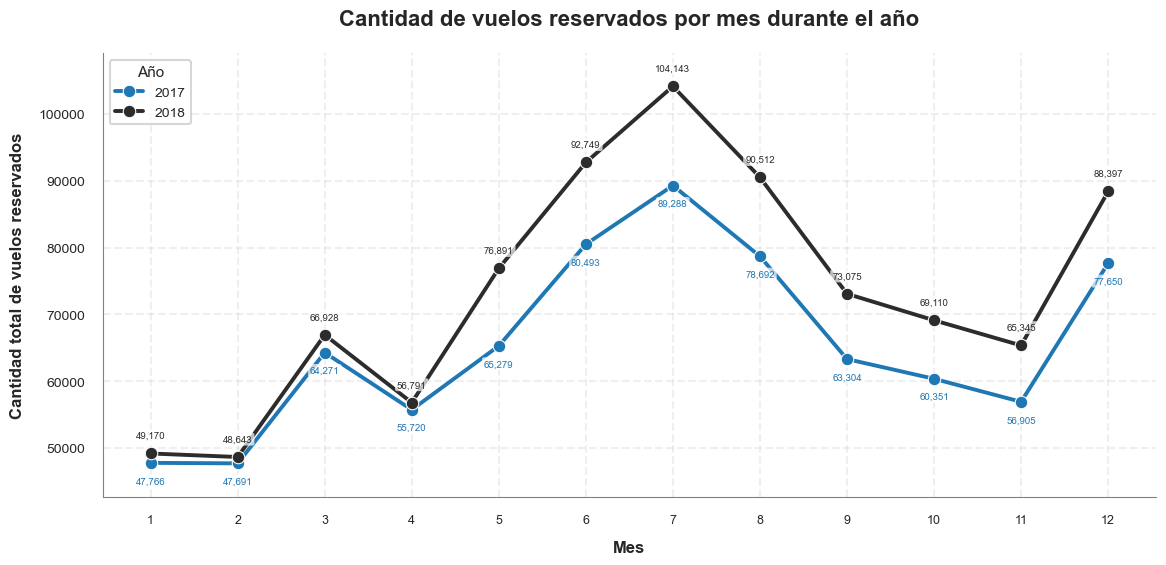

In [23]:
# CONFIGURACIÓN INICIAL DEL ESTILO GRÁFICO

# Configuración general de estilo con Seaborn:
# - "whitegrid": fondo blanco con cuadrícula ligera, ideal para datos numéricos.
# - "context='talk'": texto un poco más grande, pensado para presentaciones.
# - "font_scale=1.0": tamaño de fuente estándar.
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Personalización estética de los ejes con Matplotlib:
# - Color gris para los bordes de los ejes (más suave que negro).
# - Grosor del borde ajustado a 0.8 para un aspecto más limpio.
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.8


# AGRUPACIÓN DE DATOS

# Agrupamos el DataFrame original (df) por año y mes.
# En cada grupo, sumamos la cantidad total de vuelos reservados ("Flights Booked").
# Luego, reestablecemos el índice para obtener un DataFrame plano
# y lo ordenamos cronológicamente por año y mes.
vuelos_por_mes = (
    df.groupby(["Year", "Month"])["Flights Booked"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Month"])
)


# CREACIÓN DE LA FIGURA PRINCIPAL

# Creamos una figura de tamaño 12x6 pulgadas (ancho x alto).
plt.figure(figsize=(12, 6))

# Definimos una paleta personalizada:
# - Azul (#1f77b4) representará el año 2017.
# - Negro (#2c2c2c) representará el año 2018.
palette = ["#1f77b4", "#2c2c2c"]


# GRÁFICO DE LÍNEAS PRINCIPAL

# Dibujamos el gráfico principal con seaborn.lineplot():
# - x = Mes ("Month")
# - y = Vuelos reservados ("Flights Booked")
# - hue = Año ("Year") para distinguir líneas por color.
# - marker="o" para marcar cada punto con un círculo.
# - linewidth=2.8 para que las líneas sean gruesas y visibles.
# - palette=palette usa los colores definidos arriba.
sns.lineplot(
    data=vuelos_por_mes,
    x="Month",
    y="Flights Booked",
    hue="Year",
    marker="o",
    linewidth=2.8,
    palette=palette
)


# ETIQUETAS DE DATOS

# Recorremos los dos años (2017 y 2018) y agregamos etiquetas numéricas
# sobre o debajo de los puntos, dependiendo del color (año).

for year, color in zip(vuelos_por_mes["Year"].unique(), palette):
    # Subconjunto del DataFrame correspondiente al año actual
    subset = vuelos_por_mes[vuelos_por_mes["Year"] == year]

    # Recorremos cada fila (mes) del subconjunto
    for _, row in subset.iterrows():

        
        # POSICIÓN DE LAS ETIQUETAS
        
        # Año 2018 → línea negra → etiquetas por encima del punto.
        if year == 2018:
            y_offset = 2000   # Desplazamiento hacia arriba.
            va_align = "bottom"  # Alineación vertical desde la parte inferior del texto.

        # Año 2017 → línea azul → etiquetas por debajo del punto.
        else:
            y_offset = -2000  # Desplazamiento hacia abajo.
            va_align = "top"  # Alineación vertical desde la parte superior del texto.

        # Añadimos el texto (etiqueta numérica) en cada punto.
        plt.text(
            row["Month"],                      # Coordenada X → Mes
            row["Flights Booked"] + y_offset,  # Coordenada Y → Valor con desplazamiento
            f"{int(row['Flights Booked']):,}", # Texto formateado con separador de miles
            ha="center",                       # Centrado horizontalmente respecto al punto
            va=va_align,                       # Alineación vertical según el desplazamiento
            fontsize=7,                        # 🔹 Tamaño de fuente ligeramente mayor (antes era 6)
            color=color,                       # Mismo color que la línea
            bbox=dict(                         # Fondo blanco con bordes redondeados
                facecolor="white", alpha=0.7,  # Fondo blanco semitransparente
                edgecolor="none", boxstyle="round,pad=0.2"
            )
        )


# PERSONALIZACIÓN ESTÉTICA FINAL


# Título del gráfico con fuente grande y en negrita.
plt.title(
    "Cantidad de vuelos reservados por mes durante el año",
    fontsize=16, fontweight="bold", pad=20
)

# Etiquetas de los ejes en negrita.
plt.xlabel("Mes", fontsize=12, fontweight="bold", labelpad=10)
plt.ylabel("Cantidad total de vuelos reservados", fontsize=12, fontweight="bold", labelpad=10)

# Configuración de las marcas (ticks) de los ejes:
# - Eje X: meses del 1 al 12.
# - Eje Y: fuente ligeramente más grande.
plt.xticks(range(1, 13), fontsize=9)
plt.yticks(fontsize=10)


# AJUSTE DE LÍMITES Y LEYENDA

# Calculamos el valor mínimo y máximo de los vuelos reservados.
y_min = vuelos_por_mes["Flights Booked"].min()
y_max = vuelos_por_mes["Flights Booked"].max()

# Ajustes:
# Bajamos un poco el eje X (aumentando el margen inferior)
# para que las etiquetas inferiores (azules) no se superpongan con el eje.
plt.ylim(y_min - 5000, y_max + 5000)

# Configuración de la leyenda:
# - Muestra los años con su color correspondiente.
# - Incluye título, tamaño de texto y marco decorativo.
plt.legend(
    title="Año",
    title_fontsize=11,
    fontsize=10,
    loc="upper left",
    frameon=True,
    fancybox=True
)


# DETALLES VISUALES FINALES

# Cuadrícula tenue (líneas discontinuas grises) para facilitar lectura.
plt.grid(True, which="major", linestyle="--", alpha=0.3)

# Quita los bordes superior y derecho del gráfico (más limpio).
sns.despine(left=False, bottom=False)

# Ajusta los márgenes para que todos los elementos se vean bien.
plt.tight_layout()


# MOSTRAR GRÁFICO FINAL


# Renderiza el gráfico completo en pantalla.
plt.show()



Queremos analizar una variable cuantitativa como es “Flights Booked” a lo largo de un eje temporal, que en este casos son los meses, diferenciada por año.

**Justificación de la elección del tipo de gráfico. Gráfico de Líneas**

Para representar la distribución de la cantidad de vuelos reservados por mes durante el año, se ha seleccionado un gráfico de líneas, cuya elección corresponde a varios criterios:

1. Naturaleza temporal de la variable. La variable Month representa una secuencia ordenada de tiempo (de enero a diciembre), siendo el gráfico de líneas el más adecuado para mostrar la evolución continua de la cantidad de vuelos a lo largo del año. 


2. Comparación entre periodos (años). Cada línea corresponde a un año distinto, lo que permite comparar patrones estacionales y detectar variaciones interanuales de forma clara y directa.


3. Claridad visual y precisión. La inclusión de marcadores en cada punto mensual y etiquetas numéricas discretas mejora la legibilidad de los valores exactos, sin comprometer la estética del gráfico.


4. Comunicación efectiva de la estacionalidad. Dado que el número de vuelos reservados refleja un comportamiento estacional (mayor en algunos meses del año), el gráfico de líneas permite observar de manera inmediata los picos y descensos de actividad dentro de cada año, reforzando el análisis interpretativo de los datos.

**Explicación Gráfico**

El gráfico muestra la evolución mensual de los vuelos reservados en 2017 y 2018.

En ambos años se observa una tendencia estacional clara, con un aumento progresivo de reservas desde abril hasta un pico máximo en julio, seguido de una caída hacia los meses de otoño.

El año 2018 presenta niveles superiores de reservas en todos los meses, destacando un máximo de más de 100.000 vuelos en julio, lo que sugiere un mayor volumen de actividad o demanda respecto a 2017.

#### 2. RELACIÓN ENTRE LA DISTANCIA DE LOS VUELOS Y LOS PUNTOS ACUMULADOS POR LOS CLIENTES 

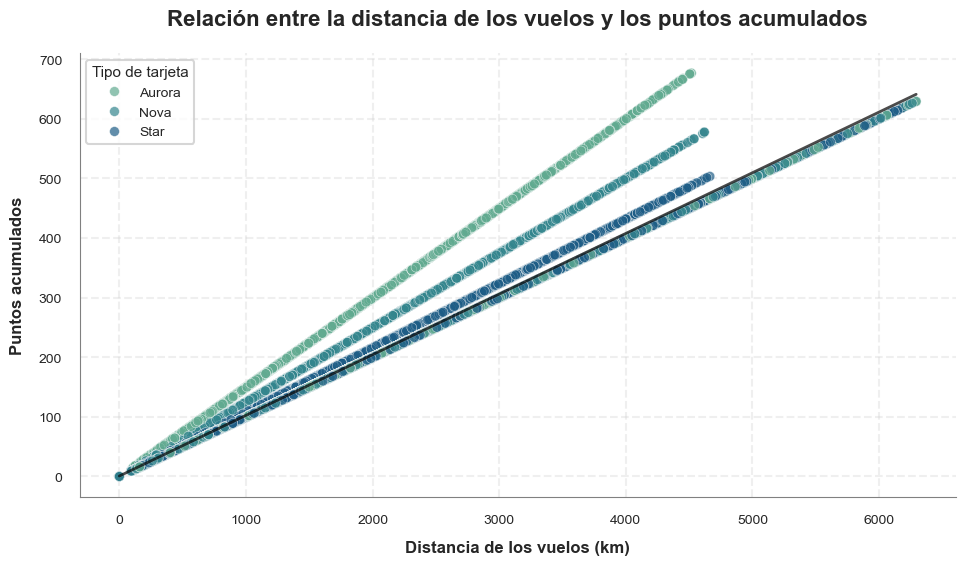

In [24]:
# CONFIGURACIÓN INICIAL DEL ESTILO GRÁFICO

# Configuramos el estilo visual general de los gráficos con Seaborn:
# - "whitegrid": fondo blanco con cuadrícula gris clara, útil para comparar valores numéricos.
# - "context='talk'": aumenta el tamaño del texto, pensado para presentaciones o reportes.
# - "font_scale=1.0": mantiene el tamaño estándar de las fuentes.
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Ajustes estéticos adicionales con Matplotlib:
# - Color gris para los bordes de los ejes (más suave que negro puro).
# - Grosor del borde de los ejes de 0.8 para un acabado limpio.
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.8


# CREACIÓN DE LA FIGURA

# Definimos el tamaño del lienzo de la figura (ancho=10, alto=6 pulgadas).
plt.figure(figsize=(10, 6))


# GRÁFICO DE DISPERSIÓN (SCATTER PLOT)


# Creamos un gráfico de dispersión que muestra la relación entre:
# - Eje X: "Distance" (distancia de los vuelos)
# - Eje Y: "Points Accumulated" (puntos acumulados)
# Cada punto representa un cliente o vuelo, coloreado según el tipo de tarjeta de lealtad.
sns.scatterplot(
    data=df,                    # DataFrame que contiene los datos
    x="Distance",               # Variable del eje X
    y="Points Accumulated",     # Variable del eje Y
    hue="Loyalty Card",         # Colorea los puntos según el tipo de tarjeta
    palette="crest",            # Paleta de colores suaves y armónicos
    alpha=0.7,                  # Transparencia ligera para evitar saturación visual
    s=50,                       # Tamaño de los puntos
    edgecolor="white",          # Borde blanco para destacar los puntos
    linewidth=0.4               # Grosor del borde de cada punto
)


# LÍNEA DE TENDENCIA GLOBAL


# Agregamos una línea de regresión (tendencia) general:
# - "scatter=False" evita que dibuje de nuevo los puntos.
# - "color='black'" la hace destacarse del resto de los datos.
# - "lw=2" define el grosor de la línea.
# - "alpha=0.7" le da un poco de transparencia.
sns.regplot(
    data=df,
    x="Distance",
    y="Points Accumulated",
    scatter=False,
    color="black",
    line_kws={"lw": 2, "alpha": 0.7}
)


# PERSONALIZACIÓN ESTÉTICA DEL GRÁFICO


# Título principal del gráfico, en tamaño grande y negrita.
plt.title(
    "Relación entre la distancia de los vuelos y los puntos acumulados",
    fontsize=16,
    fontweight="bold",
    pad=20  # Espacio entre el título y el gráfico
)

# Nombres de los ejes:
# En negrita, con tamaño medio y separación respecto al eje.
plt.xlabel("Distancia de los vuelos (km)", fontsize=12, fontweight="bold", labelpad=10)
plt.ylabel("Puntos acumulados", fontsize=12, fontweight="bold", labelpad=10)

# Ajuste de tamaño de las etiquetas de los ejes (valores numéricos)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


# LEYENDA


# Añadimos una leyenda descriptiva que indique qué color representa cada tipo de tarjeta.
plt.legend(
    title="Tipo de tarjeta",    # Título de la leyenda
    title_fontsize=11,          # Tamaño de la fuente del título
    fontsize=10,                # Tamaño del texto de los ítems
    loc="upper left",           # Ubicación de la leyenda
    frameon=True,               # Cuadro visible alrededor
    fancybox=True               # Bordes redondeados
)


# DETALLES FINALES

# Cuadrícula ligera para facilitar la lectura de valores.
plt.grid(True, linestyle="--", alpha=0.3)

# Eliminamos los bordes superiores y derechos para un diseño más limpio.
sns.despine(left=False, bottom=False)

# Ajuste automático de los márgenes para que todos los elementos encajen bien.
plt.tight_layout()


# MOSTRAR EL GRÁFICO FINAL

# Renderiza y muestra el gráfico completo.
plt.show()


**Justificación de la elección del tipo de gráfico. Gráfico de dispersión o scatter plot, con línea de tendencia, regresión lineal.**

Se ha utilizado un gráfico de dispersión con línea de tendencia, porque es la manera más directa y estadísticamente informativa de mostrar la relación cuantitativa entre dos variables numéricas continuas, permitiendo además comparar subgrupos de forma visualmente limpia.

**Explicación del gráfico**

El gráfico de dispersión con línea de tendencia muestra la relación entre la distancia recorrida en los vuelos (km) y los puntos acumulados por los clientes dentro del programa de lealtad, diferenciados por el tipo de tarjeta (Aurora, Nova y Star).

La relación es claramente lineal y positva entre ambas variables: a medida que aumenta la distancia volada, se incrementa de manera proporcional la cantidad de puntos acumulados.
Esto confirma que el sistema de recompensas se comporta de manera coherente y predecible, asignando puntos en función directa a la distancia recorrida.

Las tres líneas principales identificadas en la gráfica corresponden a los diferentes niveles de tarjeta de fidelización, cada una con una tasa de acumulación distinta:

- Aurora presenta la pendiente más pronunciada, indicando que sus titulares acumulan más puntos por cada kilómetro volado.

- Nova muestra una relación intermedia.

- Star refleja la menor tasa de acumulación de puntos respecto a la distancia.

Esto es coherente con la jerarquización que suele ser habitual en los beneficios de los programas de lealtad, es decir, las tarjetas superiores suelen otorgar mayores beneficios. 

Además de las tres líneas esperadas, se observa una cuarta franja de puntos paralela a las tendencias principales. Este fenómeno no implica la existencia de una cuarta categoría de tarjeta, sino que probablemente se deba a variaciones internas o ajustes en el sistema de cálculo de puntos.

#### 3.DISTRIBUCIÓN DE LOS CLIENTES POR PROVINCIA O ESTADO

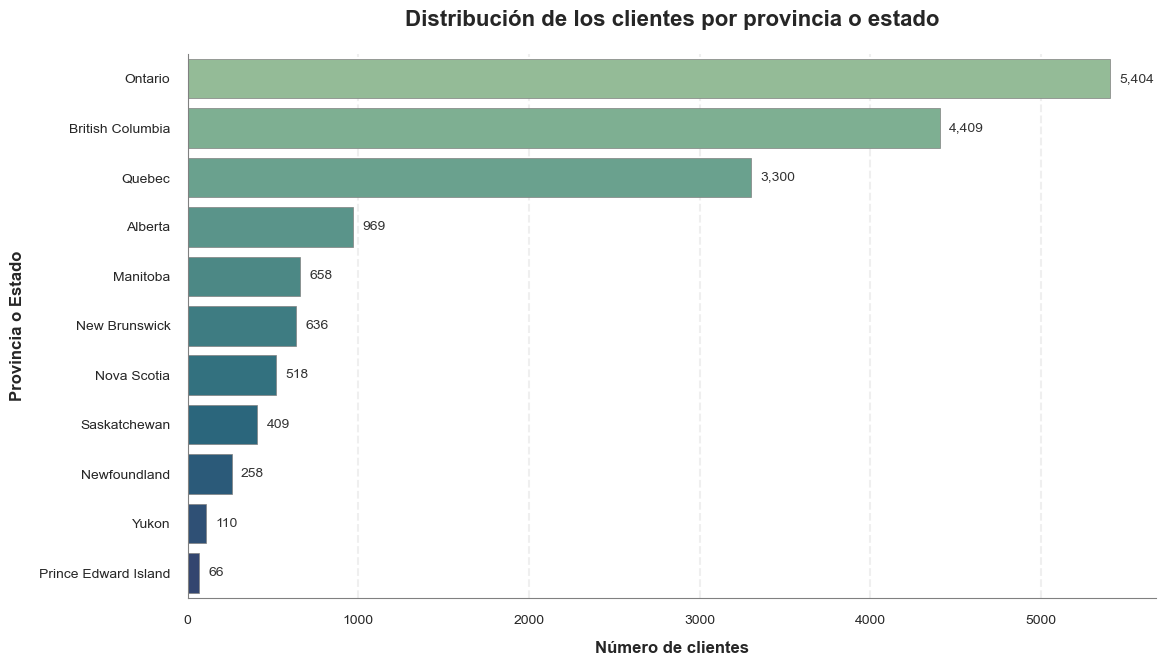

In [25]:
# CONFIGURACIÓN INICIAL DEL ESTILO GRÁFICO

# Configuración visual general de Seaborn:
# - "whitegrid": fondo blanco con cuadrícula gris clara.
# - "context='talk'": texto un poco más grande, ideal para presentaciones.
# - "font_scale=1.0": escala normal de fuente.
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Ajustes adicionales con Matplotlib:
# - Color gris para bordes de los ejes.
# - Grosor de borde moderado para un acabado más limpio.
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.8


# AGRUPACIÓN DE DATOS

# Agrupamos por "Province" (provincia o estado) y contamos el número de clientes únicos.
# Después renombramos la columna resultante y ordenamos los valores de forma descendente.
clientes_por_provincia = (
    df.groupby("Province")["Loyalty Number"]
    .nunique()  # Número de clientes únicos
    .reset_index()
    .rename(columns={"Loyalty Number": "Número de clientes"})
    .sort_values("Número de clientes", ascending=False)
)


# FIGURA PRINCIPAL
# Definimos el tamaño del gráfico (ancho x alto en pulgadas).
plt.figure(figsize=(12, 7))


# GRÁFICO DE BARRAS HORIZONTALES

# Corrección del FutureWarning:
# Se añade hue="Province" y legend=False para evitar el aviso en futuras versiones de Seaborn.
# Esto mantiene los colores y evita mostrar una leyenda redundante.
ax = sns.barplot(
    data=clientes_por_provincia,
    y="Province",                   # Eje Y → provincias
    x="Número de clientes",         # Eje X → número de clientes únicos
    hue="Province",                 # Añadido para evitar FutureWarning
    palette="crest",                # Paleta de colores suaves y consistentes
    edgecolor="gray",               # Bordes grises para contraste
    linewidth=0.5,                  # Grosor del borde de cada barra
    legend=False                    # Evita mostrar una leyenda innecesaria
)


# ETIQUETAS NUMÉRICAS EN LAS BARRAS

# Añadimos los valores numéricos al final de cada barra para mayor claridad.
for i, v in enumerate(clientes_por_provincia["Número de clientes"]):
    ax.text(
        v + (max(clientes_por_provincia["Número de clientes"]) * 0.01),  # Desplazamiento a la derecha
        i,                                                               # Posición vertical de la barra
        f"{v:,}",                                                        # Formato con separador de miles
        color="#333333",                                                 # Color gris oscuro (más visible)
        va="center",                                                     # Centrado vertical respecto a la barra
        fontsize=10                                                      # Tamaño de fuente legible
    )


# Título principal en negrita y con margen superior.
plt.title(
    "Distribución de los clientes por provincia o estado",
    fontsize=16,
    fontweight="bold",
    pad=20
)

# Nombres de los ejes en negrita y con separación del gráfico.
plt.xlabel("Número de clientes", fontsize=12, fontweight="bold", labelpad=10)
plt.ylabel("Provincia o Estado", fontsize=12, fontweight="bold", labelpad=10)

# Ajustes del tamaño de texto de los valores de los ejes.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Cuadrícula ligera solo en el eje X (ayuda a leer los valores).
plt.grid(axis="x", linestyle="--", alpha=0.3)

# Elimina los bordes superior y derecho del gráfico para un acabado más limpio.
sns.despine(left=False, bottom=False)

# Ajuste automático para evitar que los textos o títulos se corten.
plt.tight_layout()


# MOSTRAR EL GRÁFICO FINAL

plt.show()



**Justificación de la elección del tipo de gráfico. Gráfico de barras**

El gráfico de barras es el más apropiado para representar la distribución de frecuencias o conteos en variables categóricas, como en este caso la variable Province (provincia o estado).
Province es una variable categórica que identifica categorías discretas como son los nombres de provincias o estados. Por su parte el número de clientes por provincia es una variable numérica discreta, resultado de un conteo. 

El gráfico de barras es el más adecuado porque representa de manera precisa, ordenada y visualmente clara la cantidad de clientes por provincia o estado, permitiendo comparar magnitudes entre categorías y destacar las regiones con mayor o menor presencia de clientes.

Es, en definitiva, el tipo de visualización más informativo y legible para analizar distribuciones categóricas basadas en conteos o frecuencias.


**Explicación del gráfico**

Se observa una concentración notable de clientes en las provincias más pobladas y económicamente relevantes:

- Ontario encabeza la lista con 5.404 clientes, siendo la región con la mayor representación en el programa.

- Le siguen British Columbia (4.409) y Quebec (3.300), que también destacan como mercados relevantes.

- A partir de Alberta (969 clientes), el número de participantes desciende progresivamente, mostrando una distribución decreciente hacia las provincias atlánticas y del norte.

- Las provincias con menor participación son Prince Edward Island (66 clientes) y Yukon (110 clientes), lo que podría deberse a una menor densidad de población o menor penetración del programa en esas regiones.


La distribución de clientes refleja la estructura demográfica y económica del país: las regiones más grandes y pobladas concentran la mayoría de los miembros del programa de lealtad, mientras que las provincias más pequeñas presentan una participación significativamente menor. Esta conclusión cobra especial relevancia desde el punto de vista por ejemplo de estrategias de marketing. 


#### 4. COMPARACIÓN DEL SALARIO PROMEDIO ENTRE LOS DIFERENTES NIVELES EDUCATIVOS DE LOS CLIENTES

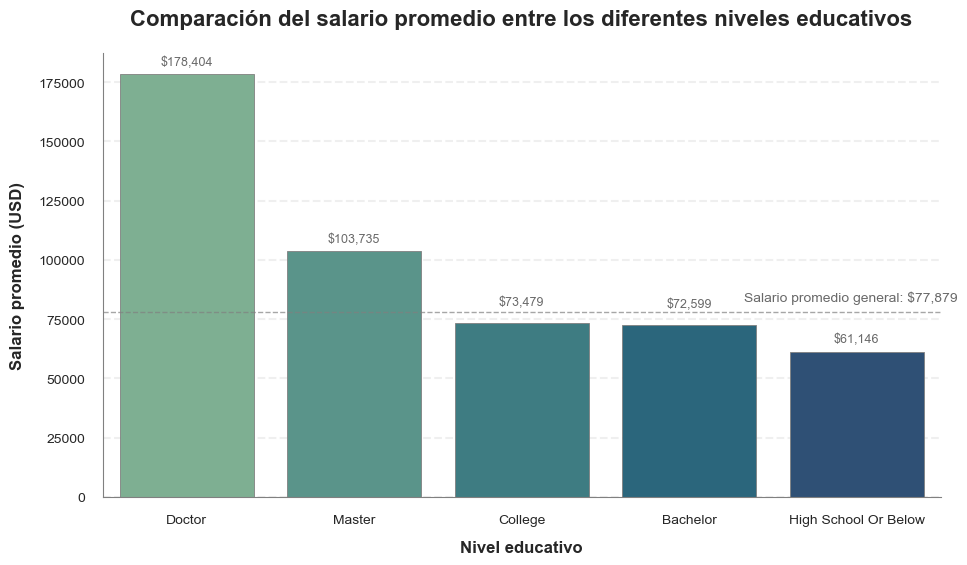

In [26]:

# CONFIGURACIÓN ESTÉTICA GLOBAL

# Configuración general del estilo visual con Seaborn:
# - "whitegrid": fondo blanco con cuadrícula gris clara (ideal para valores numéricos).
# - "context='talk'": texto más grande, útil para presentaciones o informes.
# - "font_scale=1.0": mantiene el tamaño de fuente estándar.
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Ajustes de Matplotlib para mantener coherencia visual y estilo profesional.
plt.rcParams.update({
    "axes.edgecolor": "gray",      # Bordes grises (más suaves que negros)
    "axes.linewidth": 0.8,         # Grosor del borde de los ejes
    "axes.titleweight": "bold",    # Títulos en negrita
    "axes.titlesize": 16,          # Tamaño del título del gráfico
    "axes.labelsize": 12,          # Tamaño de las etiquetas de los ejes
    "xtick.labelsize": 10,         # Tamaño de las etiquetas del eje X
    "ytick.labelsize": 10          # Tamaño de las etiquetas del eje Y
})


# AGRUPACIÓN Y CÁLCULO DE SALARIOS

# Agrupamos el DataFrame original por "Education" (nivel educativo)
# y calculamos el salario promedio para cada grupo.
# Luego se ordenan los resultados de mayor a menor.
salario_educacion = (
    df.groupby("Education")["Salary"]
    .mean()  # Cálculo del salario promedio por nivel educativo
    .reset_index()  # Convierte el índice en columna normal
    .rename(columns={"Salary": "Salario promedio"})  # Renombra la columna para mayor claridad
    .sort_values("Salario promedio", ascending=False)  # Orden descendente
)

# Calculamos el salario promedio general (referencia para línea discontinua).
salario_promedio_global = df["Salary"].mean()


# CREACIÓN DE LA FIGURA PRINCIPAL

# Definimos el tamaño del gráfico: 10 pulgadas de ancho x 6 de alto.
plt.figure(figsize=(10, 6))


# GRÁFICO DE BARRAS

# Creamos un gráfico de barras verticales con Seaborn.
# Se añade "hue='Education'" y "legend=False" para evitar el FutureWarning
# sobre el uso de "palette" sin especificar una variable de color.
ax = sns.barplot(
    data=salario_educacion,      # DataFrame que contiene los datos procesados
    x="Education",               # Eje X: niveles educativos
    y="Salario promedio",        # Eje Y: salario promedio (USD)
    hue="Education",             # Se usa hue para evitar el FutureWarning
    palette="crest",             # Paleta de colores suaves y armónicos
    edgecolor="gray",            # Bordes grises alrededor de cada barra
    linewidth=0.6,               # Grosor de los bordes
    legend=False                 # Se desactiva la leyenda (redundante)
)


# LÍNEA DE REFERENCIA DEL SALARIO GLOBAL

# Dibujamos una línea discontinua gris que indica el salario promedio general.
plt.axhline(
    salario_promedio_global,     # Altura de la línea (valor del salario promedio global)
    color="gray",                # Color gris discreto
    linestyle="--",              # Línea discontinua
    linewidth=1,                 # Grosor moderado
    alpha=0.7                    # Ligera transparencia
)

# Añadimos una etiqueta descriptiva encima de la línea de referencia.
# Indica el valor numérico del salario promedio general.
plt.text(
    x=len(salario_educacion) - 0.4,  # Posición horizontal (hacia el final del gráfico)
    y=salario_promedio_global + salario_educacion["Salario promedio"].max() * 0.02,  # Ligeramente por encima de la línea
    s=f"Salario promedio general: ${salario_promedio_global:,.0f}",  # Texto con formato de miles
    color="dimgray",             # Color gris oscuro para buena legibilidad
    fontsize=10,                 # Tamaño de fuente medio
    fontweight="medium",         # Peso medio (ni muy fino ni muy grueso)
    ha="right",                  # Alineación horizontal a la derecha
    va="bottom",                 # Alineación vertical en la parte inferior
    bbox=dict(                   # Fondo blanco semitransparente para destacar el texto
        facecolor="white",
        edgecolor="none",
        alpha=0.7,
        pad=3
    )
)


# ETIQUETAS DE VALOR ENCIMA DE LAS BARRAS

# Añadimos las etiquetas con los valores exactos del salario sobre cada barra.
# Estas ayudan a visualizar rápidamente los valores sin tener que leer el eje Y.

for i, row in enumerate(salario_educacion.itertuples()):
    # Ajuste de altura según categoría (para evitar que se solapen con la línea de referencia).
    if row.Education in ["Bachelor", "College"]:
        offset = salario_educacion["Salario promedio"].max() * 0.035  # Etiquetas un poco más arriba
    else:
        offset = salario_educacion["Salario promedio"].max() * 0.015  # Altura estándar para el resto

    # Dibujamos el texto sobre cada barra
    ax.text(
        i,                                  # Posición X (corresponde a cada barra)
        row._2 + offset,                    # Posición Y ajustada
        f"${row._2:,.0f}",                  # Texto con formato de miles y sin decimales
        ha="center",                        # Centrado horizontalmente sobre la barra
        va="bottom",                        # Alineado desde la parte inferior del texto
        fontsize=9,                         # Tamaño de fuente legible
        color="dimgray",                    # Color gris oscuro
        fontweight="medium"                 # Peso medio del texto
    )


# PERSONALIZACIÓN FINAL DEL GRÁFICO

# Título principal del gráfico, centrado y con negrita.
plt.title(
    "Comparación del salario promedio entre los diferentes niveles educativos",
    pad=20  # Espacio entre el título y el gráfico
)

# Nombres de los ejes en negrita, tal como solicitaste.
plt.xlabel("Nivel educativo", fontsize=12, fontweight="bold", labelpad=10)
plt.ylabel("Salario promedio (USD)", fontsize=12, fontweight="bold", labelpad=10)

# Mostramos las categorías del eje X en posición horizontal (sin rotación).
plt.xticks(rotation=0, ha="center")

# Añadimos una cuadrícula horizontal tenue para facilitar la comparación entre barras.
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Quitamos los bordes superior y derecho para una apariencia más moderna y limpia.
sns.despine(left=False, bottom=False)

# Ajuste automático de márgenes para que no se corte ningún texto o etiqueta.
plt.tight_layout()


# MOSTRAR EL GRÁFICO FINAL

plt.show()




**Justificación de la elección del tipo de gráfico. Gráfico de barras verticales**

Nivel educativo es una variable categórica ordinal, ya que representa categorías con un orden lógico (por ejemplo, High School → Bachelor → Master → Doctor).

Salario promedio es una variable numérica continua, que puede tomar un amplio rango de valores y se expresa en una escala cuantitativa.

Este tipo de gráfico evita la superposición de puntos y la sobrecarga visual que se produciría con otros tipos de representaciones (como los gráficos de dispersión o boxplots) cuando el interés principal no es la distribución de los datos, sino la comparación de medias.

En síntesis, el gráfico de barras verticales se ajusta de manera óptima al tipo de variables analizadas, una categórica y una numérica, y permite visualizar de forma clara, jerárquica y comparativa cómo varía el salario promedio según el nivel educativo de los clientes.


**Explicación del gráfico**

Cada barra muestra el salario promedio (en USD) para un grupo de personas según su nivel educativo.

En el eje X aparecen las categorías educativas (de menor a mayor nivel académico).

En el eje Y se muestra el salario promedio correspondiente a cada grupo.

La línea gris discontinua indica el salario promedio general del conjunto de datos ($77,879), lo que permite comparar cada grupo respecto al promedio global.


Puede verse como:

- Doctorado: presenta el salario promedio más alto ($178,404), más del doble del promedio general. Indica que el nivel educativo superior está claramente asociado con mayores ingresos.

- Máster: también se sitúa por encima del promedio, con $103,735, evidenciando un incremento notable respecto a los niveles inferiores.

- College y Bachelor: ambos grupos se mantienen en torno a los $72,000–$73,000, muy próximos entre sí y ligeramente por debajo del promedio general.

- High School or Below: es el grupo con el menor salario promedio ($61,146), significativamente inferior al promedio global.

#### 5. PROPORCIÓN DE CLIENTES CON DIFERENTES TIPOS DE TARJETAS DE FIDELIDAD

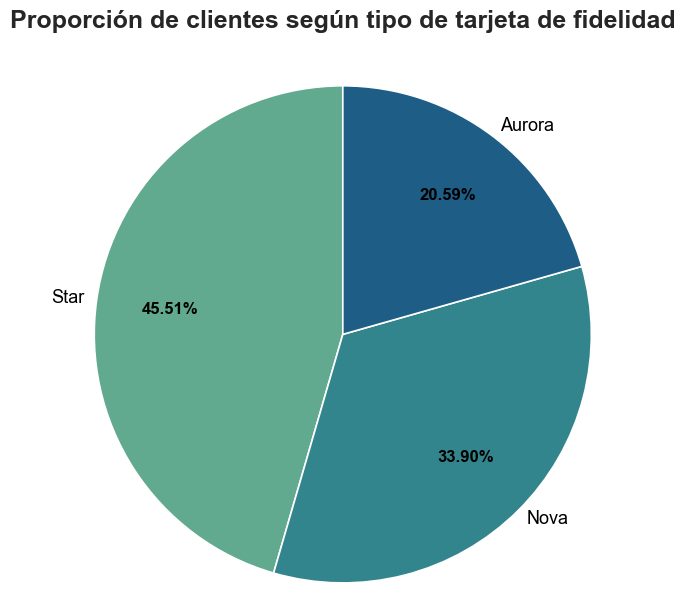

In [27]:

# CONFIGURACIÓN ESTÉTICA GLOBAL

# Configuración de estilo general con Seaborn:
# - "whitegrid": fondo blanco con cuadrícula clara.
# - "context='talk'": texto más grande, ideal para presentaciones.
# - "font_scale=1.0": mantiene el tamaño estándar de fuente.
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Personalización adicional con Matplotlib:
# Controla el estilo de los bordes, tamaños de texto y títulos.
plt.rcParams.update({
    "axes.edgecolor": "gray",     # Bordes grises en lugar de negros
    "axes.linewidth": 0.8,        # Grosor de los ejes
    "axes.titleweight": "bold",   # Títulos en negrita
    "axes.titlesize": 18,         # Tamaño del título principal
    "axes.labelsize": 12,         # Tamaño de las etiquetas de ejes
    "xtick.labelsize": 10,        # Tamaño del texto del eje X
    "ytick.labelsize": 10         # Tamaño del texto del eje Y
})



# CARGA Y AGRUPACIÓN DE DATOS


# Columna de interés: tipo de tarjeta de fidelidad del cliente
col = "Loyalty Card"

# Contamos el número de clientes por tipo de tarjeta (frecuencia absoluta)
card_counts = df[col].value_counts()

# Calculamos el porcentaje que representa cada tipo de tarjeta
# (frecuencia relativa multiplicada por 100)
card_percent = card_counts / card_counts.sum() * 100



# CREACIÓN DEL GRÁFICO DE PASTEL


# Creamos la figura y el eje del gráfico
# figsize define el tamaño total (ancho x alto en pulgadas)
fig, ax = plt.subplots(figsize=(6.5, 6.5))

# Definimos la paleta de colores "crest" (tonos azules-verdes)
# n_colors adapta el número de colores al número de categorías
colors = sns.color_palette("crest", n_colors=len(card_counts))

# Dibujamos el gráfico circular con las proporciones de cada tipo de tarjeta
wedges, texts, autotexts = ax.pie(
    card_counts,                       # Valores absolutos (frecuencias)
    labels=card_counts.index,          # Etiquetas de cada categoría
    autopct=lambda p: f"{p:.2f}%",     # Porcentajes con dos decimales
    startangle=90,                     # Rotación inicial del gráfico (90° = empieza arriba)
    colors=colors,                     # Paleta de colores
    radius=0.85,                       # Tamaño del círculo (1 sería el máximo)
    pctdistance=0.7,                   # Distancia de los porcentajes al centro
    labeldistance=1.05,                # Distancia de las etiquetas al borde exterior
    textprops={"fontsize": 13, "color": "black"},  # Etiquetas externas (negras y más grandes)
    wedgeprops={"edgecolor": "white", "linewidth": 1.2}  # Bordes blancos entre sectores
)


# TÍTULO DEL GRÁFICO

# Título centrado, en negrita, con un espacio adicional por encima
ax.set_title(
    "Proporción de clientes según tipo de tarjeta de fidelidad",
    fontsize=18,
    fontweight="bold",
    pad=25
)

# AJUSTE DE PORCENTAJES INTERNOS


# Personalizamos los textos automáticos que muestran los porcentajes dentro del gráfico.
# En esta versión:
# - Están en color negro (mejor legibilidad sobre colores claros)
# - En negrita
# - Con tamaño medio
plt.setp(
    autotexts,
    fontweight="bold",   # Texto en negrita
    color="black",       # Porcentajes en negro
    fontsize=12          # Tamaño de letra equilibrado
)


# AJUSTES FINALES DEL GRÁFICO


# Aseguramos que el gráfico sea perfectamente circular (sin deformación).
ax.axis("equal")

# Ajuste automático de márgenes para que los textos no se corten.
plt.tight_layout()

# Muestra el gráfico final en pantalla.
plt.show()


**Justificación de la elección del tipo de gráfico. Gráfico de pastel o circular**

El gráfico de pastel se ha elegido porque el objetivo del análisis es mostrar la proporción de clientes según el tipo de tarjeta de fidelidad dentro del total.
Esta variable es categórica y mutuamente excluyente (cada cliente posee un solo tipo de tarjeta), por lo que el interés principal no está en comparar valores absolutos, sino en visualizar cómo se distribuye el conjunto de clientes entre las distintas categorías.

Este tipo de gráfico es el más adecuado para visualizar qué  proporción ocupa cada categoría respecto al 100 % total. Cada sector del círculo refleja una categoría y su tamaño es proporcional al número de clientes que la poseen, lo que permite identificar fácilmente cuál es el tipo de tarjeta más frecuente y cómo se relacionan los demás con él.

Además, al tratarse de una variable con pocas categorías (tres en este caso: Aurora, Nova y Star), este gráfico es especialmente adecuado, ya que mantiene la claridad visual y evita la sobrecarga informativa que podría producir un gráfico de barras para un número tan reducido de grupos.

**Explicación del gráfico**

Star (45.5 %)
Es el tipo de tarjeta más común, representando casi la mitad de los clientes del programa. Esto sugiere que la categoría Star puede corresponder a un nivel básico con mayor accesibilidad o popularidad.

Nova (33.9 %)
Es la segunda categoría más frecuente, concentrando aproximadamente un tercio de los clientes. Su peso relativo es significativo, aunque menor que el de Star, lo que podría indicar un nivel superior pero con menor adopción.

Aurora (20.6 %)
Es la categoría menos común, con apenas una quinta parte de los clientes. Esto podría corresponder a un nivel premium o restringido del programa de fidelidad.

#### 6. CÓMO SE DISTRIBUYEN LOS CLIENTES SEGÚN SU ESTADO CIVIL Y GÉNERO

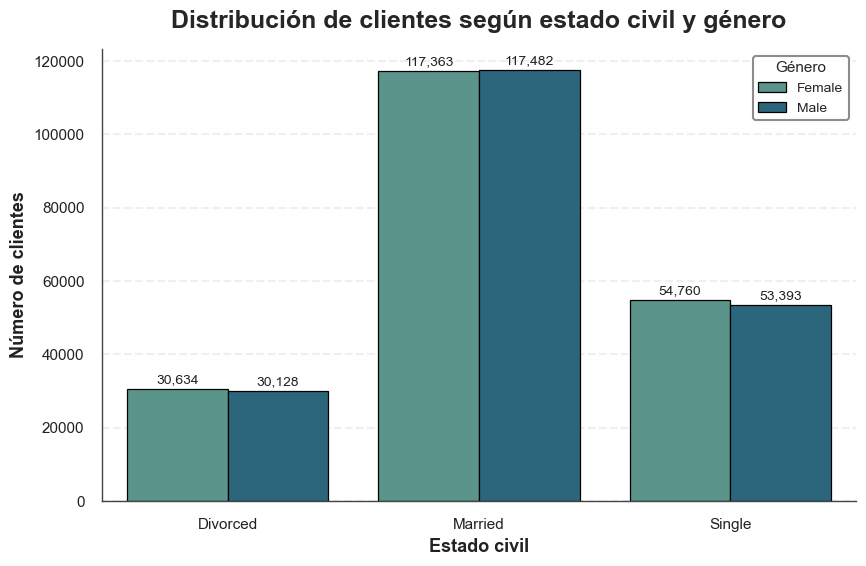

In [28]:
# CONFIGURACIÓN ESTÉTICA GLOBAL

# Configuración del estilo visual general:
# - "whitegrid": fondo blanco con cuadrícula gris sutil.
# - "context='talk'": texto más grande
# - "font_scale= 1.0": mantiene la escala de fuentes estándar.
sns.set(style="whitegrid", context="talk", font_scale=1.0)

# Ajustes adicionales en Matplotlib para afinar la estética del gráfico.
# Los ejes se oscurecen ligeramente (#444444) para mejor contraste.
# Se aumenta el grosor del borde de los ejes.
plt.rcParams.update({
    "axes.edgecolor": "#444444",   # Color gris oscuro para los ejes
    "axes.linewidth": 1.0,         # Grosor moderado de los ejes
    "axes.titleweight": "bold",    # Títulos en negrita
    "axes.titlesize": 18,          # Tamaño del título principal
    "axes.labelsize": 12,          # Tamaño de las etiquetas de los ejes
    "xtick.labelsize": 11,         # Tamaño de las etiquetas del eje X
    "ytick.labelsize": 11          # Tamaño de las etiquetas del eje Y
})



# AGRUPACIÓN DE DATOS

# Agrupamos el DataFrame por estado civil y género, contamos clientes en cada grupo.
# La columna resultante "Clientes" contendrá el conteo por categoría.
marital_gender = (
    df.groupby(["Marital Status", "Gender"])
    .size()
    .reset_index(name="Clientes")  # Renombramos la columna de conteo
)



# CREACIÓN DEL GRÁFICO DE BARRAS AGRUPADAS

# Definimos el tamaño del gráfico: 9 pulgadas de ancho x 6 de alto.
plt.figure(figsize=(9, 6))

# Paleta de colores elegida: tonos suaves (azules y verdes).
palette = sns.color_palette("crest", n_colors=2)

# Creamos el gráfico de barras agrupadas:
# Cada categoría de "Marital Status" mostrará una barra por género.
ax = sns.barplot(
    data=marital_gender,   # DataFrame con los datos
    x="Marital Status",    # Eje X → estado civil
    y="Clientes",          # Eje Y → número de clientes
    hue="Gender",          # Agrupación por género
    palette=palette,       # Paleta de colores definida
    edgecolor="black",     # Bordes negros para mayor definición
    linewidth=0.9          # Grosor de los bordes de las barras
)


# ETIQUETAS DE VALORES SOBRE LAS BARRAS

# Añadimos etiquetas con los valores exactos sobre cada barra.
# Esto permite ver los números sin depender de la escala del eje Y.
for container in ax.containers:
    ax.bar_label(
        container,                                # Conjunto de barras
        labels=[f"{v:,.0f}" for v in container.datavalues],  # Formato con separador de miles
        label_type="edge",                        # Coloca la etiqueta en el borde superior
        fontsize=10,                              # Tamaño del texto
        color="#222222",                          # Texto más oscuro para mejor contraste
        fontweight="medium",                      # Peso medio (intermedio entre normal y bold)
        padding=2                                 # Espacio entre texto y barra
    )



# PERSONALIZACIÓN FINAL DEL GRÁFICO

# Título principal del gráfico con un pequeño margen superior.
plt.title(
    "Distribución de clientes según estado civil y género",
    pad=15
)

# Etiquetas de los ejes en negrita y con color más oscuro para mejor legibilidad.
plt.xlabel("Estado civil", fontsize=13, fontweight="bold", color="#222222")
plt.ylabel("Número de clientes", fontsize=13, fontweight="bold", color="#222222")

# Las categorías del eje X e Y se muestran con un color más oscuro también.
plt.xticks(rotation=0, ha="center", color="#222222")  # Categorías del eje X más oscuras
plt.yticks(color="#222222")                           # Valores del eje Y más oscuros

# Añadimos una cuadrícula horizontal tenue para facilitar la comparación visual.
plt.grid(axis="y", linestyle="--", alpha=0.3)



# LEYENDA

# Configuración detallada de la leyenda:
# - Fondo blanco y bordes grises suaves para integrarse con el diseño general.
plt.legend(
    title="Género",           # Título de la leyenda
    title_fontsize=11,        # Tamaño del título de la leyenda
    fontsize=10,              # Tamaño del texto
    loc="upper right",        # Posición (esquina superior derecha)
    frameon=True,             # Activa el recuadro de la leyenda
    facecolor="white",        # Fondo blanco para contraste
    edgecolor="gray",         # Bordes grises del cuadro
    fancybox=True,            # Bordes redondeados
    framealpha=0.9            # Ligera transparencia
)



# DETALLES ESTÉTICOS FINALES

# Quita los bordes superior y derecho del gráfico para un estilo más limpio y moderno.
sns.despine(left=False, bottom=False)

# Ajusta los márgenes automáticamente para evitar recortes de texto.
plt.tight_layout()

# Muestra el gráfico final en pantalla.
plt.show()



**Justificación de la elección del tipo de gráfico. Gráfico de barras agrupadas**

Este tipo de gráfico, permite comparar valores absolutos o frecuencias de dos variables categóricas a la vez. Cada grupo muestra las barras de cada género una junto a otra, facilitando la comparación directa dentro del grupo.

Al mismo tiempo, se puede observar cómo cambia la distribución general del número de clientes entre los diferentes estados civiles.

Esto no sería posible por ejemplo con un gráfico de pastel o pie chart porque solo representa una variable categórica, no permite comparar dos dimensiones a la vez. 

Permite comparar simultáneamente dos variables categóricas (estado civil y género).

Facilita la comparación tanto entre categorías principales (p. ej., casados vs. solteros) como dentro de cada grupo (diferencia entre géneros).

Su formato de barras agrupadas mantiene una lectura precisa de los valores absolutos, conservando la claridad visual incluso con varias categorías.


**Explicación del gráfico**

El grupo mayoritario corresponde a los clientes casados (Married), con más de 117.000 individuos de cada género, lo que indica que el programa de fidelidad tiene una fuerte presencia entre matrimonios.

Los clientes solteros (Single) constituyen el segundo grupo más numeroso, con alrededor de 54.000 mujeres y 53.000 hombres, mostrando un equilibrio muy similar entre géneros.

El grupo divorciado (Divorced) es el menos representado, con poco más de 30.000 clientes por género.

En general, el gráfico muestra una distribución muy equilibrada entre hombres y mujeres en todos los estados civiles, sin diferencias significativas de género dentro de cada grupo.


### BONUS

### BONUS. Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

Utilizando el conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes. Tendremos en mente que los datos que tenemos son solo una muestra de una población. Para ello, los pasos que deberás seguir son: 

1. **Preparación de Datos:**
Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

1. **Análisis Descriptivo:**
Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, mediana, la desviación estándar) del número de vuelos reservados para cada grupo. Aquí, utilizamos estadística descriptiva normal.

1. **Prueba Estadística:**
Realiza una prueba de hipótesis para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos. Aquí utilizamos estadística inferencial.

#### 1. PREPARACIÓN DE LOS DATOS

In [29]:
# Seleccionar únicamente las columnas relevantes
df_bonus = df[["Flights Booked", "Education"]].copy()

# Verificar estructura y tipos de datos
print("Dimensiones del subconjunto:", df_bonus.shape)
print("\nTipos de datos:")
print(df_bonus.dtypes)

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(df_bonus.isnull().sum())

# Vista rápida de los primeros registros
print("\nPrimeras filas del conjunto filtrado:")
print(df_bonus.head())

Dimensiones del subconjunto: (403760, 2)

Tipos de datos:
Flights Booked     int64
Education         object
dtype: object

Valores nulos por columna:
Flights Booked    0
Education         0
dtype: int64

Primeras filas del conjunto filtrado:
   Flights Booked Education
0               3  Bachelor
1              10   College
2               6   College
3               0  Bachelor
4               0  Bachelor


In [30]:
df_bonus.head()

,Flights Booked,Education
0,3,Bachelor
1,10,College
2,6,College
3,0,Bachelor
4,0,Bachelor


#### 2. ANÁLISIS DESCRIPTIVO

In [32]:
# ANÁLISIS DESCRIPTIVO DEL NÚMERO DE VUELOS SEGÚN EDUCACIÓN

# Importamos las librerías necesarias:
# - seaborn: para paletas de color y estilo visual.
# - display (de IPython): para mostrar tablas estilizadas de forma limpia en notebooks.
import seaborn as sns
from IPython.display import display

# SELECCIÓN Y AGRUPACIÓN DE DATOS

# Agrupamos los datos por nivel educativo ('Education')
# y calculamos las principales estadísticas descriptivas sobre los vuelos reservados.
stats_edu = (
    df_bonus.groupby("Education")  # Agrupamos por nivel educativo
      .agg(
          Total_Clientes=("Flights Booked", "count"),       # Número de clientes en cada grupo educativo
          Media_Vuelos=("Flights Booked", "mean"),          # Promedio de vuelos reservados
          Mediana_Vuelos=("Flights Booked", "median"),      # Mediana (valor central)
          Desviacion_Estandar=("Flights Booked", "std"),    # Medida de dispersión
          Minimo=("Flights Booked", "min"),                 # Valor mínimo de vuelos
          Maximo=("Flights Booked", "max")                  # Valor máximo de vuelos
      )
      .sort_values("Media_Vuelos", ascending=False)          # Ordenamos los grupos de mayor a menor promedio
      .round(2)                                              # Redondeamos todos los resultados a 2 decimales
)



# FORMATO VISUAL Y ESTILO DE TABLA

# Definimos un colormap (paleta de color) suave y profesional
# basado en tonos azules y verdes ('crest'), coherente con los gráficos anteriores.
cmap_crest = sns.color_palette("crest", as_cmap=True)


# Mostramos la tabla con formato visual más atractivo:
# - Se aplica un gradiente de color sobre la columna de la media.
# - Se formatean los valores numéricos a 2 decimales.
# - Se incluye un título descriptivo al pie de la tabla.
display(
    stats_edu.style
         .background_gradient(cmap=cmap_crest, subset=["Media_Vuelos"])  # Gradiente visual sobre la media
         .format({                                                       # Formato numérico (dos decimales)
             "Media_Vuelos": "{:.2f}",
             "Mediana_Vuelos": "{:.2f}",
             "Desviacion_Estandar": "{:.2f}"
         })
         .set_caption("DISTRIBUCIÓN DE VUELOS RESERVADOS POR NIVEL EDUCATIVO")  
)


# PROMEDIO GLOBAL (REFERENCIA GENERAL)

# Calculamos el promedio general de vuelos reservados en toda la muestra.
# Este valor sirve como referencia para comparar con las medias de cada nivel educativo.
overall_mean = df_bonus["Flights Booked"].mean()
print(f"\nPromedio general de vuelos reservados en toda la muestra: {overall_mean:.2f}")



# INFORMACIÓN ADICIONAL SOBRE LA DISTRIBUCIÓN

# Mostramos información adicional útil sobre la dispersión de los datos:
# 1. Rango total: diferencia entre el valor mínimo y máximo de vuelos reservados.
# 2. Número de categorías educativas únicas (niveles distintos de educación).
print(f"\nRango total de vuelos reservados: {df_bonus['Flights Booked'].min()} – {df_bonus['Flights Booked'].max()}")
print(f"Niveles educativos únicos: {df_bonus['Education'].nunique()}")



,Total_Clientes,Media_Vuelos,Mediana_Vuelos,Desviacion_Estandar,Minimo,Maximo
Education,,,,,,
Master,12287,4.20,1.00,5.21,0,21
High School Or Below,18915,4.18,1.00,5.24,0,21
Doctor,17731,4.18,1.00,5.26,0,21
College,102260,4.17,1.00,5.25,0,21
Bachelor,252567,4.11,1.00,5.22,0,21



Promedio general de vuelos reservados en toda la muestra: 4.13

Rango total de vuelos reservados: 0 – 21
Niveles educativos únicos: 5


#### 3. ANÁLISIS INFERENCIAL

In [34]:

# 2. VERIFICACIÓN DE SUPUESTOS DEL ANOVA 

import numpy as np
from scipy import stats  # Importamos correctamente scipy.stats

print("\n===== VERIFICACIÓN DE SUPUESTOS =====")


# 2.1 PRUEBA DE NORMALIDAD (Shapiro-Wilk con ajuste para grandes muestras)


# Nota: SciPy lanza una advertencia cuando N > 5000, ya que el p-valor pierde precisión.
# Por ello, limitamos la muestra a 5000 observaciones por grupo para mantener validez estadística.

print("\nPrueba de normalidad (Shapiro-Wilk, máx. 5000 muestras por grupo):")

for name, group in df_bonus.groupby("Education"):  # Usamos df_bonus
    data = group["Flights Booked"].values

    # Si el grupo tiene más de 5000 observaciones, tomamos una muestra aleatoria sin reemplazo
    if len(data) > 5000:
        data = np.random.choice(data, 5000, replace=False)
    
    # Aplicamos la prueba de Shapiro-Wilk sobre la muestra (o todo el grupo si n <= 5000)
    stat, p = stats.shapiro(data)
    print(f" - {name:25s} → p = {p:.4f} (n = {len(data)})")

# Interpretación:
# Si p ≥ 0.05 → no se rechaza la normalidad (los datos del grupo pueden considerarse normales)
# Si p < 0.05 → el grupo no sigue una distribución normal



# 2.2 PRUEBA DE HOMOGENEIDAD DE VARIANZAS (Levene)


# Esta prueba evalúa si las varianzas de los grupos son iguales.
# Es un requisito importante para aplicar correctamente el ANOVA.

# Creamos una lista con los valores de "Flights Booked" para cada grupo
groups = [group["Flights Booked"].values for _, group in df_bonus.groupby("Education")]

levene_stat, levene_p = stats.levene(*groups)

print(f"\nPrueba de homogeneidad de varianzas (Levene): p = {levene_p:.4f}")

# Interpretación del resultado de Levene
if levene_p >= 0.05:
    print("Las varianzas pueden considerarse homogéneas (se cumple el supuesto).")
else:
    print("Las varianzas difieren significativamente entre grupos (violación del supuesto).")



# 3. APLICACIÓN DE LA PRUEBA ANOVA DE UNA VÍA


# ANOVA evalúa si existen diferencias significativas en las medias de los grupos.
# Supone normalidad y homogeneidad de varianzas.

f_stat, p_value = stats.f_oneway(*groups)

print("\n===== RESULTADOS DE LA PRUEBA ANOVA =====")
print(f"Estadístico F: {f_stat:.4f}")
print(f"Valor p: {p_value:.6f}")

# Nivel de significancia
alpha = 0.05

# Interpretación de resultados
if p_value < alpha:
    print("\nConclusión: Se RECHAZA la hipótesis nula (H₀).")
    print("Existe evidencia estadísticamente significativa de que el número de vuelos reservados difiere según el nivel educativo.")
else:
    print("\nConclusión: NO se rechaza la hipótesis nula (H₀).")
    print("No se observan diferencias significativas en el número de vuelos reservados entre los distintos niveles educativos.")




===== VERIFICACIÓN DE SUPUESTOS =====

Prueba de normalidad (Shapiro-Wilk, máx. 5000 muestras por grupo):
 - Bachelor                  → p = 0.0000 (n = 5000)
 - College                   → p = 0.0000 (n = 5000)
 - Doctor                    → p = 0.0000 (n = 5000)
 - High School Or Below      → p = 0.0000 (n = 5000)
 - Master                    → p = 0.0000 (n = 5000)

Prueba de homogeneidad de varianzas (Levene): p = 0.0150
Las varianzas difieren significativamente entre grupos (violación del supuesto).

===== RESULTADOS DE LA PRUEBA ANOVA =====
Estadístico F: 3.5790
Valor p: 0.006353

Conclusión: Se RECHAZA la hipótesis nula (H₀).
Existe evidencia estadísticamente significativa de que el número de vuelos reservados difiere según el nivel educativo.


Se realizó una verificación de normalidad mediante la prueba de Shapiro–Wilk.
Dado que algunos grupos presentaban un tamaño de muestra superior a 5000 observaciones, se limitó la muestra a ese número para evitar advertencias del paquete SciPy y garantizar la precisión del cálculo del valor p.

Asimismo, se llevó a cabo una verificación de homogeneidad de varianzas mediante la prueba de Levene, la cual evalúa si las varianzas entre los distintos grupos son estadísticamente iguales.

Finalmente, se aplicó una prueba ANOVA de una vía, que permite comparar las medias del número de vuelos reservados entre los diferentes niveles educativos mediante el cálculo del estadístico F y su correspondiente valor p.

Cuando los datos no son normales o las varianzas son desiguales, la alternativa adecuada es la prueba de Kruskal–Wallis, que no asume normalidad ni homogeneidad y evalúa diferencias en las medianas entre grupos.


In [36]:

# PRUEBA NO PARAMÉTRICA ALTERNATIVA: KRUSKAL–WALLIS

from scipy.stats import kruskal

# Aplicamos la prueba de Kruskal–Wallis
h_stat, p_kw = kruskal(*groups)

print("\nRESULTADOS DE LA PRUEBA KRUSKAL–WALLIS")
print(f"Estadístico H: {h_stat:.4f}")
print(f"Valor p: {p_kw:.6f}")

alpha = 0.05
if p_kw < alpha:
    print("\nConclusión: Se RECHAZA la hipótesis nula (H₀).")
    print("Existen diferencias estadísticamente significativas en el número de vuelos reservados según el nivel educativo.")
else:
    print("\nConclusión: NO se rechaza la hipótesis nula (H₀).")
    print("No se observan diferencias significativas entre los niveles educativos en cuanto al número de vuelos reservados.")


RESULTADOS DE LA PRUEBA KRUSKAL–WALLIS
Estadístico H: 17.5326
Valor p: 0.001523

Conclusión: Se RECHAZA la hipótesis nula (H₀).
Existen diferencias estadísticamente significativas en el número de vuelos reservados según el nivel educativo.


Hay evidencia de que el nivel educativo influye en el número de vuelos reservados, es decir, al menos un grupo educativo se comporta de forma diferente a los demás.

Ya que Kruskal–Wallis fue significativo (p < 0.05), ahora realizamos una prueba post-hoc para identificar qué niveles educativos difieren entre sí.

La adecuada es la prueba de Dunn con corrección de Bonferroni (no paramétrica).

In [37]:
# PRUEBA POST-HOC: DUNN TEST (con corrección de Bonferroni)


import scikit_posthocs as sp
from IPython.display import display

# Aplicamos la prueba de Dunn para comparaciones múltiples
# Usamos df_bonus, que contiene las columnas "Flights Booked" y "Education"
posthoc = sp.posthoc_dunn(
    df_bonus,                      # DataFrame con los datos filtrados
    val_col="Flights Booked",      # Variable numérica
    group_col="Education",         # Grupos (niveles educativos)
    p_adjust="bonferroni"          # Corrección de Bonferroni para comparaciones múltiples
)

print("\nRESULTADOS POST-HOC (PRUEBA DE DUNN)")
display(posthoc)


RESULTADOS POST-HOC (PRUEBA DE DUNN)


,Bachelor,College,Doctor,High School Or Below,Master
Bachelor,1.000000,0.022735,0.949079,0.362961,0.142438
College,0.022735,1.000000,1.000000,1.000000,1.000000
Doctor,0.949079,1.000000,1.000000,1.000000,1.000000
High School Or Below,0.362961,1.000000,1.000000,1.000000,1.000000
Master,0.142438,1.000000,1.000000,1.000000,1.000000


Tras la aplicación del test no paramétrico de Kruskal–Wallis (H = 17.53, p = 0.0015), se realizaron comparaciones múltiples mediante la prueba de Dunn con corrección de Bonferroni.
Los resultados indican que sólo existe una diferencia estadísticamente significativa entre los grupos Bachelor y College (p = 0.0227), mientras que los demás niveles educativos no difieren entre sí.
En conjunto, estos resultados sugieren que el nivel educativo influye parcialmente en el número de vuelos reservados, aunque las diferencias se concentran en un único par de niveles.